# Compas Dataset: Calibration ver

In this notebook the optimal Deferral Net configuration is chosen, and the deferral tau threshold is calibrated.

Following the BRIDGET experimental pipeline, the Deferral Net is trained on the data predicted by the Human-in-Command process, then subsequently tested on the validation data to produce the optimal Tau deferral coefficient.

The architecture for the Nets to be tested are [(16, 8), (32, 16), (64, 32)].

The optimizer used is ADAM

The dropout rate was set to 0.2 to ensure the nets dont overfit initially, then tested up to 0.5



### Libraries and functions

In [1]:
# retrieving all libraries
%load_ext autoreload
%autoreload 2




import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import random



from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from river import rules, tree, datasets, drift, metrics, evaluate
from river import imblearn
from river import preprocessing
from river import metrics
from river import ensemble, linear_model, forest

from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from ignite.metrics import Accuracy, Loss
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import global_step_from_engine


from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper


from bridget_utils import *
from classes import BetaUser, DeferralNet, PyTorchWrapper, RiverModelWrapper
from b_xai_test import BRIDGET, HiC, MiC


26-Feb-20 22:58:00 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [2]:
def set_all_seeds(seed=42):
    
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
   
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except ImportError:
        pass

set_all_seeds(42)

In [3]:
def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predictions')
    plt.ylabel('Ground Truths')
    plt.title('Confusion Matrix, DefNet')
    plt.show()
    
    print(classification_report(all_labels, all_preds))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Expert: Accurate, Not Trusting

### Iter 1

In [ ]:
# retrieving the calibration split 

iter=1
df_val= pd.read_csv(r"processed_data\compas\calibration_datasets\iter_1\acc_nt_calibration.csv")

# retrieving data

df_acc_nt = pd.read_csv(r"processed_data\compas\hic_results_ds\iter_1\hic_accurate_not_trusting.csv")

path= f".\processed_data\compas\switch_ds\iter_{iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"acc_nt_switch.csv")

df_acc_nt.to_csv(file_path, index=False)

In [ ]:
feat_order = [c for c in df_acc_nt.columns if c not in [
    'did_recid', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction']]

X_cal, y_cal, acc_nt_loader = create_loader(df_acc_nt, feat_order, 'did_recid', batch_size=128, shuffle=False)

X_val, y_val, val_loader = create_loader(df_val, feat_order, 'did_recid', batch_size=128, shuffle=False)

#### Deferral Strat 1

chosen_ 32/16 net


##### Net 1: 16/8

tau= 0.54


In [ ]:
# Log:

# at the first trial, 
# with configuration (dropout_coeff=0.05, lr=0.001, weight_decay=1e-5, weights [1.0, 1.0], smoothing= 0.005, stepsize= 15, gamma= 0.8)
# both loss curves behaved very well, converging at the 0.65 loss wall
# overall accuracy was 0.63, however the signal from the user caused the net to achieve precision 62/69 and recall 95/16
# hence, just like the accurate, trusting user, the weights must be tweaked


# a 1.5 weight for class 1 caused collapsing over class 1
set_all_seeds(42)

small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.05)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(),
                       lr=0.001,
                       weight_decay=1e-5

                    )


weights = torch.tensor([1.0, 1.32]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.0)
scheduler = StepLR(optimizer, step_size=20, gamma=0.8) 


Training Results - Epoch[1] Avg accuracy: 0.43 Avg loss: 0.70
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.43 Avg loss: 0.70
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.43 Avg loss: 0.70
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.43 Avg loss: 0.70
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.43 Avg loss: 0.70
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.43 Avg loss: 0.70
Validation Results - Epoch[6] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

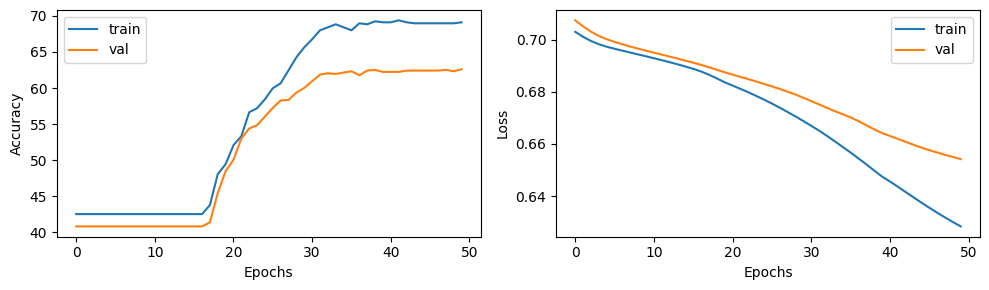

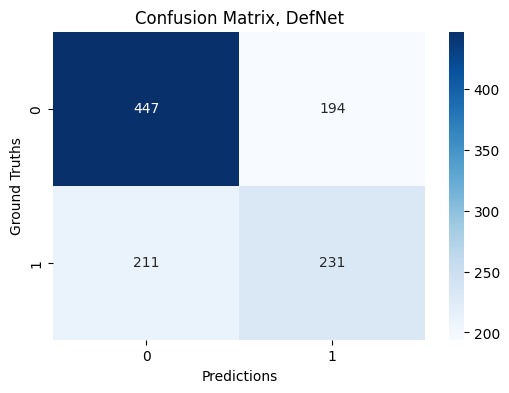

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       641
           1       0.54      0.52      0.53       442

    accuracy                           0.63      1083
   macro avg       0.61      0.61      0.61      1083
weighted avg       0.62      0.63      0.62      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\acc_nt_models'
model_name= '16_8_acc_nt'

training_history, validation_history = net_trainer(small_net, optimizer,
                                             criterion, device, acc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)



Tau Threshold

In [ ]:
model_path = fr'.\nets\compas\iter_{iter}\acc_nt_models\16_8_acc_nt_model_50.pt' 
small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.54
0.678082191780822


##### Net 2: 32/16

tau= 0.62

lo stesso valore di tau dell'altro user accurato peraltro

In [ ]:
# Log config changes:
# this one behaved really well, as expected from the other accurate users results 

# dropout fixed from 0.10 to 0.15 to keep the validation loss perfectly convex 
set_all_seeds(42)

large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.15)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(),
                       lr=0.0015,
                       weight_decay= 2e-4

                    )

weights = torch.tensor([1.0, 1.35]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.0)
scheduler = StepLR(optimizer, step_size=20, gamma=0.8) 


Training

Training Results - Epoch[1] Avg accuracy: 0.43 Avg loss: 0.69
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 1: Learning Rate 0.0015
Training Results - Epoch[2] Avg accuracy: 0.43 Avg loss: 0.69
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 2: Learning Rate 0.0015
Training Results - Epoch[3] Avg accuracy: 0.43 Avg loss: 0.69
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 3: Learning Rate 0.0015
Training Results - Epoch[4] Avg accuracy: 0.57 Avg loss: 0.69
Validation Results - Epoch[4] Avg accuracy: 0.53 Avg loss: 0.69
End of Epoch 4: Learning Rate 0.0015
Training Results - Epoch[5] Avg accuracy: 0.66 Avg loss: 0.68
Validation Results - Epoch[5] Avg accuracy: 0.62 Avg loss: 0.69
End of Epoch 5: Learning Rate 0.0015
Training Results - Epoch[6] Avg accuracy: 0.69 Avg loss: 0.68
Validation Results - Epoch[6] Avg accuracy: 0.64 Avg loss: 0.68
End of Epoch 6: Learning Rate 0.0015
Training Results - Epo

2026-02-20 20:41:56,992 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[35] Avg accuracy: 0.68 Avg loss: 0.60
Validation Results - Epoch[35] Avg accuracy: 0.63 Avg loss: 0.64
End of Epoch 35: Learning Rate 0.0012000000000000001
Training Results - Epoch[36] Avg accuracy: 0.68 Avg loss: 0.60
Validation Results - Epoch[36] Avg accuracy: 0.63 Avg loss: 0.64
End of Epoch 36: Learning Rate 0.0012000000000000001
Training Results - Epoch[37] Avg accuracy: 0.68 Avg loss: 0.60
Validation Results - Epoch[37] Avg accuracy: 0.63 Avg loss: 0.64
End of Epoch 37: Learning Rate 0.0012000000000000001


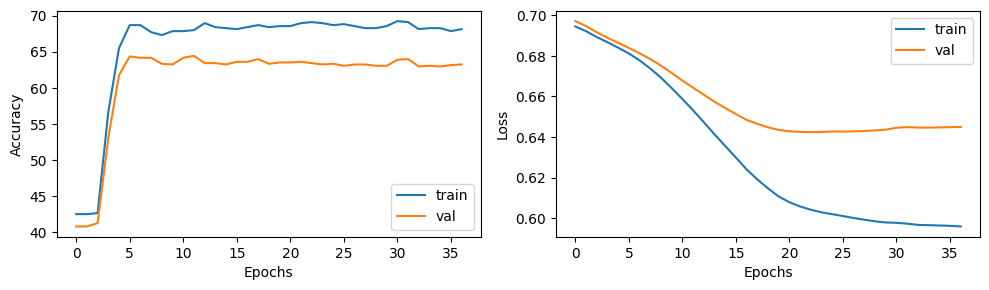

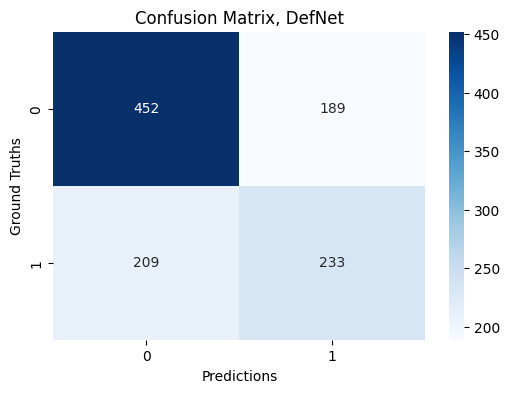

              precision    recall  f1-score   support

           0       0.68      0.71      0.69       641
           1       0.55      0.53      0.54       442

    accuracy                           0.63      1083
   macro avg       0.62      0.62      0.62      1083
weighted avg       0.63      0.63      0.63      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\acc_nt_models'
model_name= '32_16_acc_nt'

training_history, validation_history = net_trainer(large_net, optimizer,
                                             criterion, device, acc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)


Tau Threshold

In [ ]:
# dopo avere scelto la net migliore

model_path = fr'nets\compas\iter_{iter}\acc_nt_models\32_16_acc_nt_model_37.pt' 
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.62
0.6875957120980092


#### Deferral Strat 2 


    thresh          acc           defer rate

11  0.193220       0.761773       0.259003

12  0.201695       0.738227       0.174515 <--- this one deferred 34% on real data

13  0.210169       0.722992       0.120499 

14  0.218644       0.700831       0.078947 <--- this one defers 25% on real data

15  0.227119       0.693906       0.044321 <--- this defers 22%

16  0.235593       0.689751       0.023546

17  0.244068       0.684211       0.009695 <--- chosen

18  0.252542       0.682825       0.004155 <--- 10% def rate

19  0.261017       0.682825       0.001385





  
  

In [ ]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_acc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [ ]:
# sulla base di x_def chiamo la rete 
set_all_seeds(42)
r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff= 0.1)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


save_dir = fr'.\r_nets\compas\iter_{iter}'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_acc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/20 - Loss: 0.5449
Epoch 2/20 - Loss: 0.5312
Epoch 3/20 - Loss: 0.4973
Epoch 4/20 - Loss: 0.4610
Epoch 5/20 - Loss: 0.4202
Epoch 6/20 - Loss: 0.3844
Epoch 7/20 - Loss: 0.3516
Epoch 8/20 - Loss: 0.3412
Epoch 9/20 - Loss: 0.3415
Epoch 10/20 - Loss: 0.3406
Epoch 11/20 - Loss: 0.3362
Epoch 12/20 - Loss: 0.3410
Epoch 13/20 - Loss: 0.3420
Epoch 14/20 - Loss: 0.3444
Epoch 15/20 - Loss: 0.3371
Epoch 16/20 - Loss: 0.3372
Epoch 17/20 - Loss: 0.3385
Epoch 18/20 - Loss: 0.3364
Epoch 19/20 - Loss: 0.3390
Epoch 20/20 - Loss: 0.3349
✅ r_net salvata correttamente in .\r_nets\compas\iter_1


In [ ]:
set_all_seeds(42)


p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.0)

net_path= fr".\nets\compas\iter_{iter}\acc_nt_models\32_16_acc_nt_model_37.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.1, 0.6, 60) # ofc adjusted the zooming only to interesting areas of the search
calibration_results = []

for tr in thresholds:
    
    defer_mask = (p_defer_calib >= tr)
    
    # accuracy custom, applichi mask + fetch correct
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.100000       1.000000       1.000000
1   0.108475       1.000000       1.000000
2   0.116949       1.000000       1.000000
3   0.125424       1.000000       1.000000
4   0.133898       0.997230       0.990305
5   0.142373       0.983380       0.950139
6   0.150847       0.959834       0.854571
7   0.159322       0.900277       0.706371
8   0.167797       0.862881       0.591413
9   0.176271       0.821330       0.459834
10  0.184746       0.788089       0.350416
11  0.193220       0.761773       0.259003
12  0.201695       0.738227       0.174515
13  0.210169       0.722992       0.120499
14  0.218644       0.700831       0.078947
15  0.227119       0.693906       0.044321
16  0.235593       0.689751       0.023546
17  0.244068       0.684211       0.009695
18  0.252542       0.682825       0.004155
19  0.261017       0.682825       0.001385
20  0.269492       0.681440       0.000000
21  0.277966       0.681440       0.000000
22  0.28644

### Iter 2

In [ ]:
# retrieving the calibration split 
iter=2

df_val= pd.read_csv(fr".\processed_data\compas\calibration_datasets\iter_{iter}\acc_nt_calibration.csv")

df_acc_nt = pd.read_csv(fr"processed_data\compas\hic_results_ds\iter_{iter}\hic_accurate_not_trusting.csv")

path= f".\processed_data\compas\switch_ds\iter_{iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"acc_nt_switch.csv")

df_acc_nt.to_csv(file_path, index=False)

In [ ]:
feat_order = [c for c in df_acc_nt.columns if c not in [
    'did_recid', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction']]

X_cal, y_cal, acc_nt_loader = create_loader(df_acc_nt, feat_order, 'did_recid', batch_size=128, shuffle=False)

X_val, y_val, val_loader = create_loader(df_val, feat_order, 'did_recid', batch_size=128, shuffle=False)

#### Deferral Strat 1


##### Net 1: 16/8

tau= 0.62


In [ ]:
# Log config changes:

# questa rete non ha neanche bisogno di label smoothing nè peso in più alla classe 1, produce risultati discreti

set_all_seeds(42)

small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.05)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(),
                       lr=0.001,
                       weight_decay=1e-5

                    )


weights = torch.tensor([1.0, 1.0]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.00)
scheduler = StepLR(optimizer, step_size=20, gamma=0.8) 


Training

Training Results - Epoch[1] Avg accuracy: 0.49 Avg loss: 0.71
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.73
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.49 Avg loss: 0.70
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.49 Avg loss: 0.70
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.49 Avg loss: 0.70
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.49 Avg loss: 0.70
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.49 Avg loss: 0.70
Validation Results - Epoch[6] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

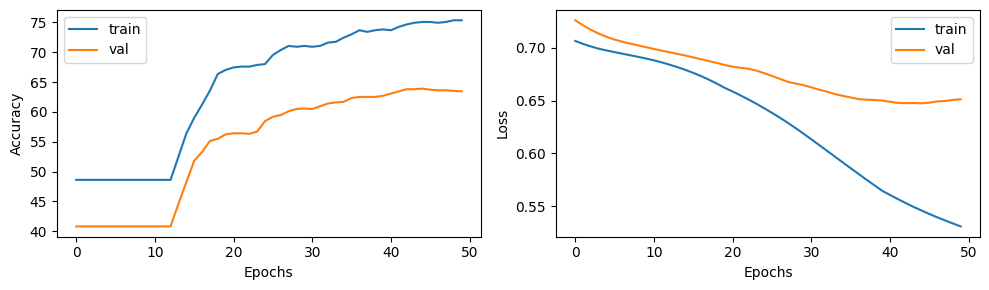

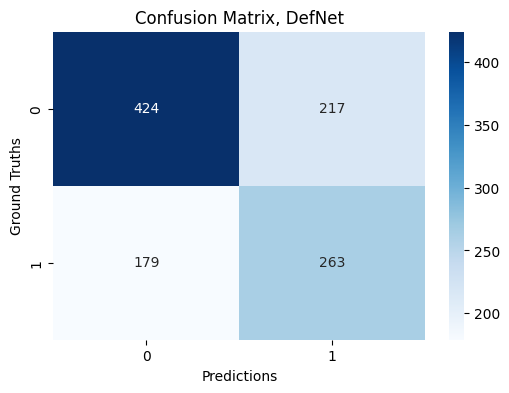

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       641
           1       0.55      0.60      0.57       442

    accuracy                           0.63      1083
   macro avg       0.63      0.63      0.63      1083
weighted avg       0.64      0.63      0.64      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\acc_nt_models'
model_name= '16_8_acc_nt'

training_history, validation_history = net_trainer(small_net, optimizer,
                                             criterion, device, acc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)



Tau Threshold

In [ ]:
model_path = fr'.\nets\compas\iter_{iter}\acc_nt_models\16_8_acc_nt_model_50.pt' 

small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.62
0.6701183431952663


##### Net 2: 32/16

tau 0.59

In [ ]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping
set_all_seeds(42)

large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.2)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(),
                       lr=0.001,
                       weight_decay= 1e-2

                    )

weights = torch.tensor([1.0, 1.0]).to(device) #1.1 troppo basso
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.00)
scheduler = StepLR(optimizer, step_size=18, gamma=0.8) 


Training

Training Results - Epoch[1] Avg accuracy: 0.49 Avg loss: 0.69
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.49 Avg loss: 0.69
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.51 Avg loss: 0.69
Validation Results - Epoch[3] Avg accuracy: 0.43 Avg loss: 0.69
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.57 Avg loss: 0.69
Validation Results - Epoch[4] Avg accuracy: 0.50 Avg loss: 0.69
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.61 Avg loss: 0.69
Validation Results - Epoch[5] Avg accuracy: 0.56 Avg loss: 0.69
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.70 Avg loss: 0.69
Validation Results - Epoch[6] Avg accuracy: 0.61 Avg loss: 0.69
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

2026-02-20 21:19:37,408 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[30] Avg accuracy: 0.76 Avg loss: 0.59
Validation Results - Epoch[30] Avg accuracy: 0.63 Avg loss: 0.64
End of Epoch 30: Learning Rate 0.0008
Training Results - Epoch[31] Avg accuracy: 0.75 Avg loss: 0.58
Validation Results - Epoch[31] Avg accuracy: 0.63 Avg loss: 0.64
End of Epoch 31: Learning Rate 0.0008
Training Results - Epoch[32] Avg accuracy: 0.75 Avg loss: 0.57
Validation Results - Epoch[32] Avg accuracy: 0.64 Avg loss: 0.64
End of Epoch 32: Learning Rate 0.0008
Training Results - Epoch[33] Avg accuracy: 0.76 Avg loss: 0.57
Validation Results - Epoch[33] Avg accuracy: 0.63 Avg loss: 0.64
End of Epoch 33: Learning Rate 0.0008
Epoch[34], Iter[200] Loss: 0.57
Training Results - Epoch[34] Avg accuracy: 0.76 Avg loss: 0.56
Validation Results - Epoch[34] Avg accuracy: 0.64 Avg loss: 0.64
End of Epoch 34: Learning Rate 0.0008


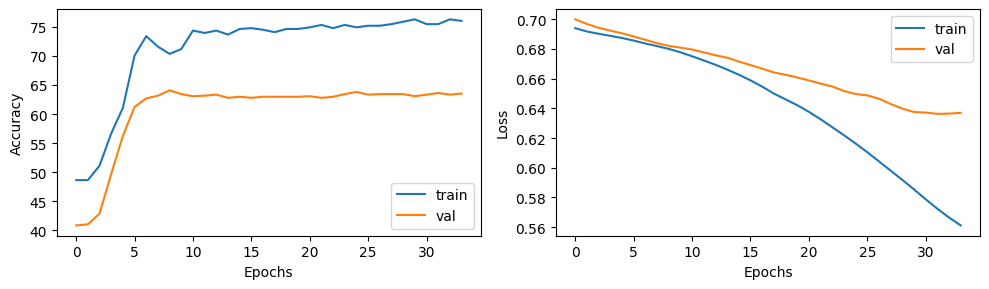

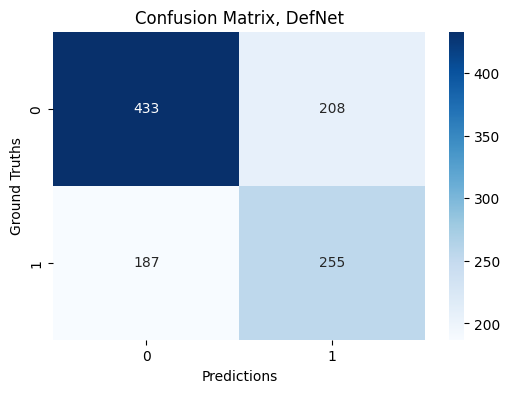

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       641
           1       0.55      0.58      0.56       442

    accuracy                           0.64      1083
   macro avg       0.62      0.63      0.63      1083
weighted avg       0.64      0.64      0.64      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\acc_nt_models'
model_name= '32_16_acc_nt'

training_history, validation_history = net_trainer(large_net, optimizer,
                                             criterion, device, acc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)


Tau Threshold

In [ ]:
# dopo avere scelto la net migliore

model_path = fr'.\nets\compas\iter_2\acc_nt_models\32_16_acc_nt_model_34.pt'
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.59
0.680119581464873


#### Deferral Strat 2 

    tau             acc          defer rate
19  0.216327       0.818560       0.222992 <-- 12%

20  0.222449       0.801939       0.162050 <-- 8%

21  0.228571       0.789474       0.121884

22  0.234694       0.785319       0.094183

23  0.240816       0.781163       0.070637  <-- this produces 2% defer rate

24  0.246939       0.775623       0.051247

In [ ]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_acc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [ ]:
# sulla base di x_def chiamo la rete 

set_all_seeds(42)
r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff= 0.18)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
save_dir = fr'.\r_nets\compas\iter_{iter}'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(30):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/30 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_acc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/30 - Loss: 0.6086
Epoch 2/30 - Loss: 0.5955
Epoch 3/30 - Loss: 0.5820
Epoch 4/30 - Loss: 0.5720
Epoch 5/30 - Loss: 0.5599
Epoch 6/30 - Loss: 0.5408
Epoch 7/30 - Loss: 0.5217
Epoch 8/30 - Loss: 0.5029
Epoch 9/30 - Loss: 0.4799
Epoch 10/30 - Loss: 0.4564
Epoch 11/30 - Loss: 0.4365
Epoch 12/30 - Loss: 0.4189
Epoch 13/30 - Loss: 0.4076
Epoch 14/30 - Loss: 0.4066
Epoch 15/30 - Loss: 0.4024
Epoch 16/30 - Loss: 0.4012
Epoch 17/30 - Loss: 0.4072
Epoch 18/30 - Loss: 0.4013
Epoch 19/30 - Loss: 0.3990
Epoch 20/30 - Loss: 0.3994
Epoch 21/30 - Loss: 0.3990
Epoch 22/30 - Loss: 0.4008
Epoch 23/30 - Loss: 0.3978
Epoch 24/30 - Loss: 0.3909
Epoch 25/30 - Loss: 0.3958
Epoch 26/30 - Loss: 0.4000
Epoch 27/30 - Loss: 0.3952
Epoch 28/30 - Loss: 0.3898
Epoch 29/30 - Loss: 0.3984
Epoch 30/30 - Loss: 0.3906
✅ r_net salvata correttamente in .\r_nets\compas\iter_2


In [ ]:
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.3)

net_path= fr".\nets\compas\iter_{iter}\acc_nt_models\32_16_acc_nt_model_34.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)
large_net.eval()

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.1, 0.4, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.100000       1.000000       1.000000
1   0.106122       1.000000       1.000000
2   0.112245       1.000000       1.000000
3   0.118367       1.000000       1.000000
4   0.124490       1.000000       1.000000
5   0.130612       1.000000       1.000000
6   0.136735       1.000000       1.000000
7   0.142857       1.000000       1.000000
8   0.148980       1.000000       1.000000
9   0.155102       1.000000       0.995845
10  0.161224       0.997230       0.981994
11  0.167347       0.995845       0.972299
12  0.173469       0.984765       0.926593
13  0.179592       0.961219       0.851801
14  0.185714       0.934903       0.754848
15  0.191837       0.918283       0.646814
16  0.197959       0.882271       0.501385
17  0.204082       0.854571       0.390582
18  0.210204       0.833795       0.288089
19  0.216327       0.818560       0.222992
20  0.222449       0.801939       0.162050
21  0.228571       0.789474       0.121884
22  0.23469

### Iter 3

In [ ]:
# retrieving the calibration split 
iter=3

df_val= pd.read_csv(fr".\processed_data\compas\calibration_datasets\iter_{iter}\acc_nt_calibration.csv")

df_acc_nt = pd.read_csv(fr"processed_data\compas\hic_results_ds\iter_{iter}\hic_accurate_not_trusting.csv")

path= f".\processed_data\compas\switch_ds\iter_{iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"acc_nt_switch.csv")

df_acc_nt.to_csv(file_path, index=False)

In [ ]:
feat_order = [c for c in df_acc_nt.columns if c not in [
    'did_recid', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction']]

X_cal, y_cal, acc_nt_loader = create_loader(df_acc_nt, feat_order, 'did_recid', batch_size=128, shuffle=False)

X_val, y_val, val_loader = create_loader(df_val, feat_order, 'did_recid', batch_size=128, shuffle=False)

#### Deferral Strat 1


##### Net 1: 16/8

tau= 0.57


In [ ]:
# Log config changes:
# this one doesnt need smoothing nor weight to class 1
# even with no dropout it behaves well
# noticeably tho, it cant go beyound 0.66, its just like the others
set_all_seeds(42)

small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.0)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(),
                       lr=0.001,
                       weight_decay=1e-5

                    )


weights = torch.tensor([1.0, 1.0]).to(device) 
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.00)
scheduler = StepLR(optimizer, step_size=20, gamma=0.8) 


Training

Training Results - Epoch[1] Avg accuracy: 0.52 Avg loss: 0.70
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.73
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.52 Avg loss: 0.70
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.73
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.52 Avg loss: 0.70
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[6] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

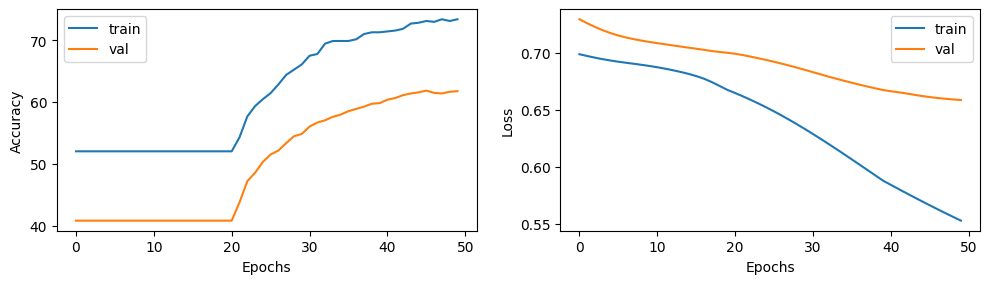

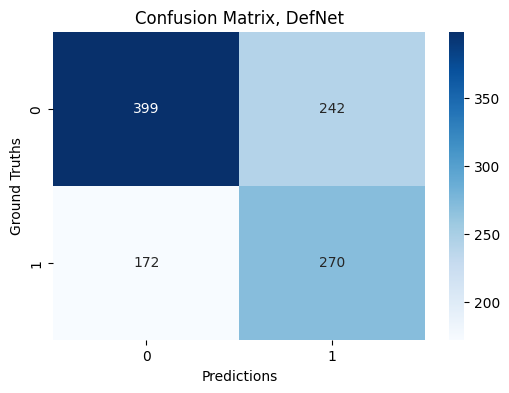

              precision    recall  f1-score   support

           0       0.70      0.62      0.66       641
           1       0.53      0.61      0.57       442

    accuracy                           0.62      1083
   macro avg       0.61      0.62      0.61      1083
weighted avg       0.63      0.62      0.62      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\acc_nt_models'
model_name= '16_8_acc_nt'

training_history, validation_history = net_trainer(small_net, optimizer,
                                             criterion, device, acc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)



Tau Threshold

In [ ]:
model_path = fr'.\nets\compas\iter_{iter}\acc_nt_models\16_8_acc_nt_model_50.pt' 

small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.5700000000000001
0.6614285714285715


##### Net 2: 32/16

tau 0.6

In [ ]:

set_all_seeds(42)

large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.2)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(),
                       lr=0.001,
                       weight_decay= 1e-2

                    )

weights = torch.tensor([1.0, 1.0]).to(device) #1.1 troppo basso
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.00)
scheduler = StepLR(optimizer, step_size=18, gamma=0.8) 

Training

Training Results - Epoch[1] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[6] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

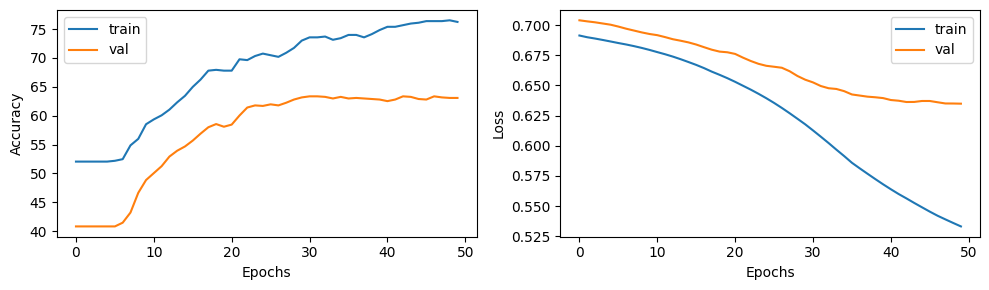

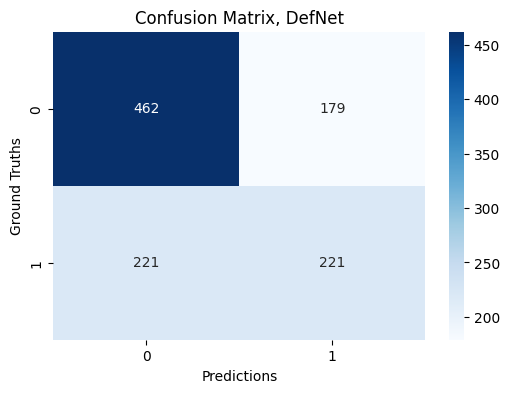

              precision    recall  f1-score   support

           0       0.68      0.72      0.70       641
           1       0.55      0.50      0.52       442

    accuracy                           0.63      1083
   macro avg       0.61      0.61      0.61      1083
weighted avg       0.63      0.63      0.63      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\acc_nt_models'
model_name= '32_16_acc_nt'

training_history, validation_history = net_trainer(large_net, optimizer,
                                             criterion, device, acc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)


Tau Threshold

In [ ]:
# dopo avere scelto la net migliore

model_path = fr'.\nets\compas\iter_3\acc_nt_models\32_16_acc_nt_model_50.pt'
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.6
0.6901615271659325


#### Deferral Strat 2 

    tau             acc           def rate

15  0.222449       0.801688       0.163150

16  0.230612       0.784810       0.091421 <--- 

17  0.238776       0.776371       0.050633

In [ ]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_acc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [ ]:
# sulla base di x_def chiamo la rete 
# same configuration as iter 2
set_all_seeds(42)
r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff= 0.18)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
save_dir = fr'.\r_nets\compas\iter_{iter}'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(30):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/30 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_acc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/30 - Loss: 0.6233
Epoch 2/30 - Loss: 0.6170
Epoch 3/30 - Loss: 0.6042
Epoch 4/30 - Loss: 0.5887
Epoch 5/30 - Loss: 0.5704
Epoch 6/30 - Loss: 0.5578
Epoch 7/30 - Loss: 0.5374
Epoch 8/30 - Loss: 0.5095
Epoch 9/30 - Loss: 0.4928
Epoch 10/30 - Loss: 0.4669
Epoch 11/30 - Loss: 0.4561
Epoch 12/30 - Loss: 0.4261
Epoch 13/30 - Loss: 0.4176
Epoch 14/30 - Loss: 0.4168
Epoch 15/30 - Loss: 0.4125
Epoch 16/30 - Loss: 0.4107
Epoch 17/30 - Loss: 0.4135
Epoch 18/30 - Loss: 0.4186
Epoch 19/30 - Loss: 0.4056
Epoch 20/30 - Loss: 0.4103
Epoch 21/30 - Loss: 0.4113
Epoch 22/30 - Loss: 0.4072
Epoch 23/30 - Loss: 0.4075
Epoch 24/30 - Loss: 0.4077
Epoch 25/30 - Loss: 0.4093
Epoch 26/30 - Loss: 0.4063
Epoch 27/30 - Loss: 0.4039
Epoch 28/30 - Loss: 0.4108
Epoch 29/30 - Loss: 0.4099
Epoch 30/30 - Loss: 0.4030
✅ r_net salvata correttamente in .\r_nets\compas\iter_3


In [ ]:
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.3)

net_path= fr".\nets\compas\iter_{iter}\acc_nt_models\32_16_acc_nt_model_50.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)
large_net.eval()

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.1, 0.5, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.100000       1.000000       1.000000
1   0.108163       1.000000       1.000000
2   0.116327       1.000000       1.000000
3   0.124490       1.000000       1.000000
4   0.132653       1.000000       1.000000
5   0.140816       1.000000       1.000000
6   0.148980       1.000000       1.000000
7   0.157143       1.000000       1.000000
8   0.165306       0.998594       0.995781
9   0.173469       0.995781       0.974684
10  0.181633       0.971871       0.887482
11  0.189796       0.932489       0.690577
12  0.197959       0.901547       0.526020
13  0.206122       0.849508       0.361463
14  0.214286       0.821378       0.251758
15  0.222449       0.801688       0.163150
16  0.230612       0.784810       0.091421
17  0.238776       0.776371       0.050633
18  0.246939       0.769339       0.033755
19  0.255102       0.766526       0.019691
20  0.263265       0.765120       0.011252
21  0.271429       0.763713       0.007032
22  0.27959

## Expert: Inaccurate, Trusting

### Iter 1

In [ ]:
iter=1
df_val= pd.read_csv(r"processed_data\compas\calibration_datasets\iter_1\inacc_t_calibration.csv")

# retrieving data

df_inacc_t = pd.read_csv(r"processed_data\compas\hic_results_ds\iter_1\hic_inaccurate_trusting.csv")

path= f".\processed_data\compas\switch_ds\iter_{iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"inacc_t_switch.csv")

df_inacc_t.to_csv(file_path, index=False)

In [ ]:
feat_order = [c for c in df_inacc_t.columns if c not in [
    'did_recid', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction']]

X_cal, y_cal, inacc_t_loader = create_loader(df_inacc_t, feat_order, 'did_recid', batch_size=128, shuffle=False)

X_val, y_val, val_loader = create_loader(df_val, feat_order, 'did_recid', batch_size=128, shuffle=False)

#### Deferral Strat 1

chosen_ 32/16 net


##### Net 1: 16/8

tau= 0.58


In [ ]:
# the issue this time was the user is so inaccurate that i had to allocate a weight to the majority class because the net only predicted
set_all_seeds(42)

small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.05)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(),
                       lr=0.001,
                       weight_decay=1e-5

                    )


weights = torch.tensor([1.0, 1.65]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.025)
scheduler = StepLR(optimizer, step_size=15, gamma=0.8) 


Training Results - Epoch[1] Avg accuracy: 0.37 Avg loss: 0.71
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.37 Avg loss: 0.70
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.37 Avg loss: 0.70
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.37 Avg loss: 0.70
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.37 Avg loss: 0.70
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.37 Avg loss: 0.70
Validation Results - Epoch[6] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

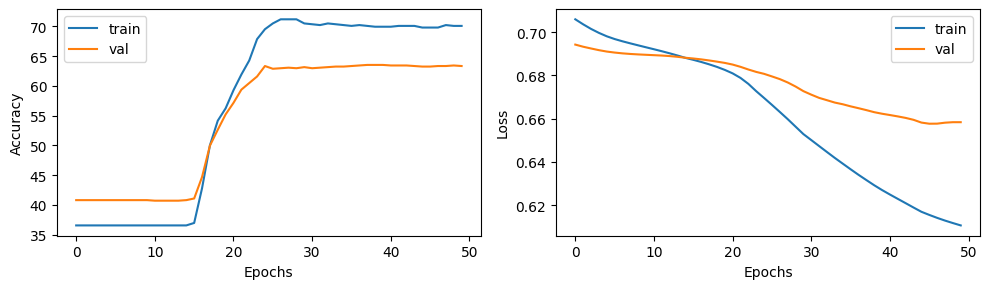

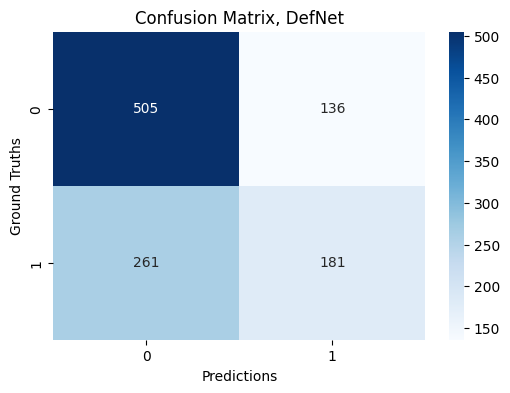

              precision    recall  f1-score   support

           0       0.66      0.79      0.72       641
           1       0.57      0.41      0.48       442

    accuracy                           0.63      1083
   macro avg       0.62      0.60      0.60      1083
weighted avg       0.62      0.63      0.62      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\inacc_t_models'
model_name= '16_8_inacc_t'

training_history, validation_history = net_trainer(small_net, optimizer,
                                             criterion, device, inacc_t_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)



Tau Threshold

In [ ]:
model_path = fr'.\nets\compas\iter_{iter}\inacc_t_models\16_8_inacc_t_model_50.pt' 
small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.58
0.7058823529411765


##### Net 2: 32/16

tau= 0.56

In [ ]:
# Log config changes:

set_all_seeds(42)

large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.2)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(),
                       lr=0.001,
                       weight_decay= 1e-4

                    )

weights = torch.tensor([1.0, 1.7]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
scheduler = StepLR(optimizer, step_size=15, gamma=0.7) 

# valid loss at 0.66 is like a wall. overall its not worth to use this structure

Training

Training Results - Epoch[1] Avg accuracy: 0.37 Avg loss: 0.70
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.37 Avg loss: 0.70
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.37 Avg loss: 0.70
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.37 Avg loss: 0.70
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.37 Avg loss: 0.70
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.37 Avg loss: 0.70
Validation Results - Epoch[6] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

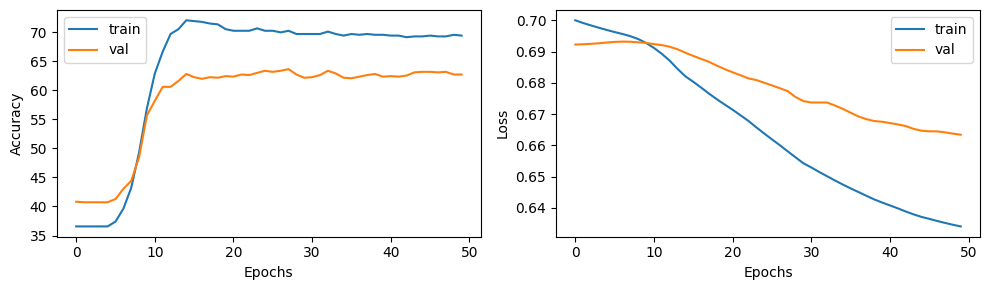

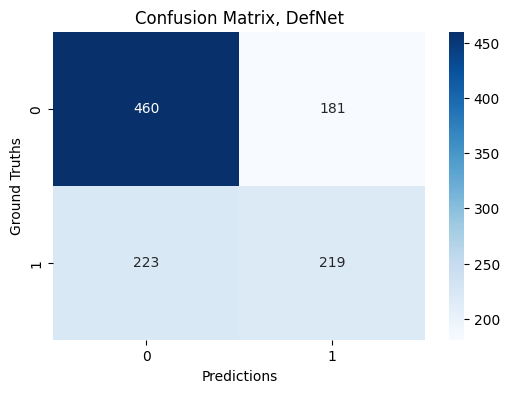

              precision    recall  f1-score   support

           0       0.67      0.72      0.69       641
           1       0.55      0.50      0.52       442

    accuracy                           0.63      1083
   macro avg       0.61      0.61      0.61      1083
weighted avg       0.62      0.63      0.62      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\inacc_t_models'
model_name= '32_16_inacc_t'

training_history, validation_history = net_trainer(large_net, optimizer,
                                             criterion, device, inacc_t_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)


Tau Threshold

In [ ]:
# dopo avere scelto la net migliore

model_path = fr'nets\compas\iter_{iter}\inacc_t_models\32_16_inacc_t_model_50.pt' 
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.56
0.7013574660633484


#### Deferral Strat 2 


    thresh         acc           defer rate

32  0.308475       0.768698       0.289474

33  0.311864       0.756233       0.246537 <-- 9% def rate on real data

34  0.315254       0.747922       0.216066 <-- 7%

35  0.318644       0.743767       0.195291


  
  

In [ ]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_inacc_t.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [ ]:
# sulla base di x_def chiamo la rete 
set_all_seeds(42)
r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff= 0.0)


optimizer = torch.optim.Adam(r_net.parameters(), lr=5e-4)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


save_dir = fr'.\r_nets\compas\iter_{iter}'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(30):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/30 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_inacc_t.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/30 - Loss: 0.6412
Epoch 2/30 - Loss: 0.6461
Epoch 3/30 - Loss: 0.6197
Epoch 4/30 - Loss: 0.6237
Epoch 5/30 - Loss: 0.6033
Epoch 6/30 - Loss: 0.6007
Epoch 7/30 - Loss: 0.5909
Epoch 8/30 - Loss: 0.5785
Epoch 9/30 - Loss: 0.5762
Epoch 10/30 - Loss: 0.5603
Epoch 11/30 - Loss: 0.5501
Epoch 12/30 - Loss: 0.5421
Epoch 13/30 - Loss: 0.5476
Epoch 14/30 - Loss: 0.5397
Epoch 15/30 - Loss: 0.5375
Epoch 16/30 - Loss: 0.5348
Epoch 17/30 - Loss: 0.5335
Epoch 18/30 - Loss: 0.5372
Epoch 19/30 - Loss: 0.5267
Epoch 20/30 - Loss: 0.5401
Epoch 21/30 - Loss: 0.5403
Epoch 22/30 - Loss: 0.5271
Epoch 23/30 - Loss: 0.5335
Epoch 24/30 - Loss: 0.5306
Epoch 25/30 - Loss: 0.5309
Epoch 26/30 - Loss: 0.5336
Epoch 27/30 - Loss: 0.5301
Epoch 28/30 - Loss: 0.5233
Epoch 29/30 - Loss: 0.5347
Epoch 30/30 - Loss: 0.5293
✅ r_net salvata correttamente in .\r_nets\compas\iter_1


In [ ]:
set_all_seeds(42)


p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.0)

net_path= fr".\nets\compas\iter_{iter}\inacc_t_models\32_16_inacc_t_model_50.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.2, 0.4, 60)
calibration_results = []

for tr in thresholds:
    
    defer_mask = (p_defer_calib >= tr)
    
    # accuracy custom, applichi mask + fetch correct
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.200000       1.000000       1.000000
1   0.203390       1.000000       1.000000
2   0.206780       1.000000       1.000000
3   0.210169       1.000000       1.000000
4   0.213559       1.000000       1.000000
5   0.216949       1.000000       1.000000
6   0.220339       1.000000       0.998615
7   0.223729       1.000000       0.997230
8   0.227119       1.000000       0.997230
9   0.230508       1.000000       0.997230
10  0.233898       1.000000       0.997230
11  0.237288       1.000000       0.995845
12  0.240678       0.997230       0.988920
13  0.244068       0.995845       0.984765
14  0.247458       0.994460       0.976454
15  0.250847       0.990305       0.961219
16  0.254237       0.987535       0.937673
17  0.257627       0.983380       0.921053
18  0.261017       0.977839       0.891967
19  0.264407       0.961219       0.846260
20  0.267797       0.950139       0.807479
21  0.271186       0.936288       0.761773
22  0.27457

### Iter 2 

In [ ]:
# retrieving the calibration split 
iter=2

df_val= pd.read_csv(fr".\processed_data\compas\calibration_datasets\iter_{iter}\inacc_t_calibration.csv")

df_inacc_t = pd.read_csv(fr"processed_data\compas\hic_results_ds\iter_{iter}\hic_inaccurate_trusting.csv")

path= f".\processed_data\compas\switch_ds\iter_{iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"inacc_t_switch.csv")

df_inacc_t.to_csv(file_path, index=False)

In [ ]:
feat_order = [c for c in df_inacc_t.columns if c not in [
    'did_recid', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction']]

X_cal, y_cal, inacc_t_loader = create_loader(df_inacc_t, feat_order, 'did_recid', batch_size=128, shuffle=False)

X_val, y_val, val_loader = create_loader(df_val, feat_order, 'did_recid', batch_size=128, shuffle=False)

#### Deferral Strat 1


##### Net 1: 16/8

tau= 0.76


In [ ]:
# Log config changes:

set_all_seeds(42)

small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.25)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(),
                       lr=0.002,
                       weight_decay=1e-4

                    )


weights = torch.tensor([1.0, 2.0]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5) 

Training

Training Results - Epoch[1] Avg accuracy: 0.19 Avg loss: 0.74
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.68
End of Epoch 1: Learning Rate 0.002
Training Results - Epoch[2] Avg accuracy: 0.19 Avg loss: 0.73
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.68
End of Epoch 2: Learning Rate 0.002
Training Results - Epoch[3] Avg accuracy: 0.19 Avg loss: 0.71
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 3: Learning Rate 0.002
Training Results - Epoch[4] Avg accuracy: 0.19 Avg loss: 0.70
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 4: Learning Rate 0.002
Training Results - Epoch[5] Avg accuracy: 0.63 Avg loss: 0.69
Validation Results - Epoch[5] Avg accuracy: 0.54 Avg loss: 0.69
End of Epoch 5: Learning Rate 0.002
Training Results - Epoch[6] Avg accuracy: 0.81 Avg loss: 0.67
Validation Results - Epoch[6] Avg accuracy: 0.59 Avg loss: 0.70
End of Epoch 6: Learning Rate 0.002
Training Results - Epoch[7] 

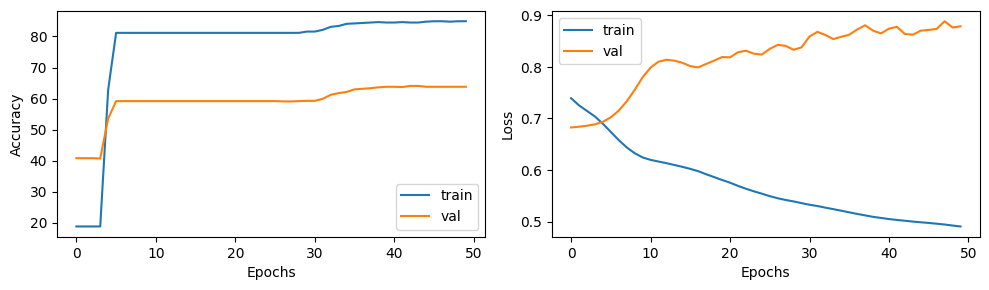

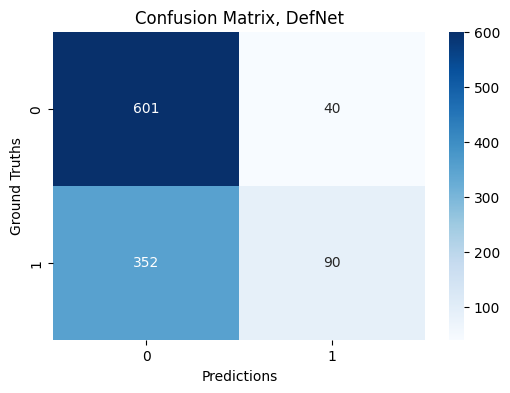

              precision    recall  f1-score   support

           0       0.63      0.94      0.75       641
           1       0.69      0.20      0.31       442

    accuracy                           0.64      1083
   macro avg       0.66      0.57      0.53      1083
weighted avg       0.66      0.64      0.57      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\inacc_t_models'
model_name= '16_8_inacc_t'

training_history, validation_history = net_trainer(small_net, optimizer,
                                             criterion, device, inacc_t_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)



Tau Threshold

In [ ]:
model_path = fr'.\nets\compas\iter_{iter}\inacc_t_models\16_8_inacc_t_model_50.pt' 

small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.76
0.6711509715994021


##### Net 2: 32/16

tau 0.63

In [ ]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping
set_all_seeds(42)

large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.21)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(),
                       lr=0.006,
                       weight_decay= 1e-2
                    )

weights = torch.tensor([1.0, 3.0]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
scheduler = StepLR(optimizer, step_size=10, gamma=0.65) 


Training

Training Results - Epoch[1] Avg accuracy: 0.19 Avg loss: 0.73
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 1: Learning Rate 0.006
Training Results - Epoch[2] Avg accuracy: 0.81 Avg loss: 0.72
Validation Results - Epoch[2] Avg accuracy: 0.59 Avg loss: 0.72
End of Epoch 2: Learning Rate 0.006
Training Results - Epoch[3] Avg accuracy: 0.81 Avg loss: 0.72
Validation Results - Epoch[3] Avg accuracy: 0.59 Avg loss: 0.75
End of Epoch 3: Learning Rate 0.006
Training Results - Epoch[4] Avg accuracy: 0.81 Avg loss: 0.72
Validation Results - Epoch[4] Avg accuracy: 0.59 Avg loss: 0.75
End of Epoch 4: Learning Rate 0.006
Training Results - Epoch[5] Avg accuracy: 0.81 Avg loss: 0.72
Validation Results - Epoch[5] Avg accuracy: 0.59 Avg loss: 0.74
End of Epoch 5: Learning Rate 0.006
Training Results - Epoch[6] Avg accuracy: 0.81 Avg loss: 0.72
Validation Results - Epoch[6] Avg accuracy: 0.59 Avg loss: 0.74
End of Epoch 6: Learning Rate 0.006
Training Results - Epoch[7] 

2026-02-20 13:25:49,157 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[44] Avg accuracy: 0.83 Avg loss: 0.63
Validation Results - Epoch[44] Avg accuracy: 0.65 Avg loss: 0.77
End of Epoch 44: Learning Rate 0.006
Training Results - Epoch[45] Avg accuracy: 0.82 Avg loss: 0.63
Validation Results - Epoch[45] Avg accuracy: 0.65 Avg loss: 0.76
End of Epoch 45: Learning Rate 0.006
Training Results - Epoch[46] Avg accuracy: 0.80 Avg loss: 0.63
Validation Results - Epoch[46] Avg accuracy: 0.65 Avg loss: 0.75
End of Epoch 46: Learning Rate 0.006


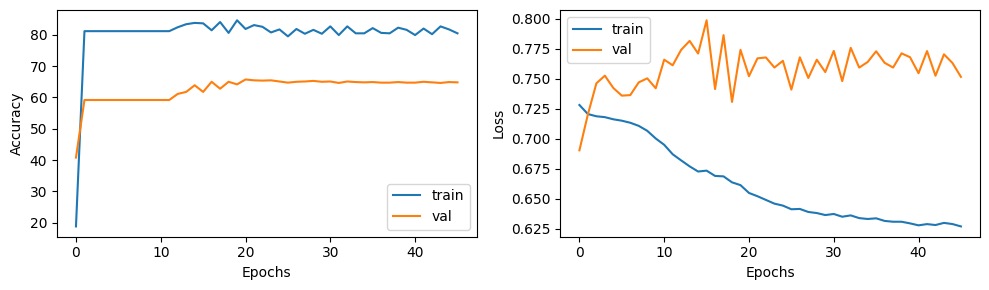

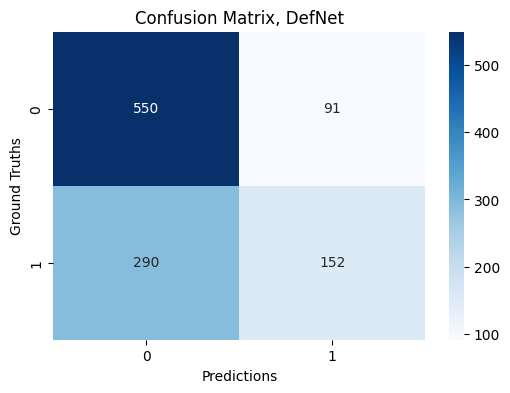

              precision    recall  f1-score   support

           0       0.65      0.86      0.74       641
           1       0.63      0.34      0.44       442

    accuracy                           0.65      1083
   macro avg       0.64      0.60      0.59      1083
weighted avg       0.64      0.65      0.62      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\inacc_t_models'
model_name= '32_16_inacc_t'

training_history, validation_history = net_trainer(large_net, optimizer,
                                             criterion, device, inacc_t_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)


Tau Threshold

In [ ]:
# dopo avere scelto la net migliore

model_path = fr'.\nets\compas\iter_2\inacc_t_models\32_16_inacc_t_model_46.pt'
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.63
0.7053435114503817


#### Deferral Strat 2 


26  0.412245       0.867036       0.229917

27  0.420408       0.815789       0.055402



In [ ]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_inacc_t.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [ ]:
# sulla base di x_def chiamo la rete 

set_all_seeds(42)
r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff= 0.20)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
save_dir = fr'.\r_nets\compas\iter_{iter}'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(30):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/30 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_inacc_t.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/30 - Loss: 0.7502
Epoch 2/30 - Loss: 0.7460
Epoch 3/30 - Loss: 0.7400
Epoch 4/30 - Loss: 0.7371
Epoch 5/30 - Loss: 0.7272
Epoch 6/30 - Loss: 0.7242
Epoch 7/30 - Loss: 0.7178
Epoch 8/30 - Loss: 0.7197
Epoch 9/30 - Loss: 0.7148
Epoch 10/30 - Loss: 0.7060
Epoch 11/30 - Loss: 0.7081
Epoch 12/30 - Loss: 0.7084
Epoch 13/30 - Loss: 0.7055
Epoch 14/30 - Loss: 0.7038
Epoch 15/30 - Loss: 0.7036
Epoch 16/30 - Loss: 0.7067
Epoch 17/30 - Loss: 0.7078
Epoch 18/30 - Loss: 0.7060
Epoch 19/30 - Loss: 0.6992
Epoch 20/30 - Loss: 0.7053
Epoch 21/30 - Loss: 0.7036
Epoch 22/30 - Loss: 0.7033
Epoch 23/30 - Loss: 0.7024
Epoch 24/30 - Loss: 0.7025
Epoch 25/30 - Loss: 0.7014
Epoch 26/30 - Loss: 0.6982
Epoch 27/30 - Loss: 0.6986
Epoch 28/30 - Loss: 0.7017
Epoch 29/30 - Loss: 0.6977
Epoch 30/30 - Loss: 0.7063
✅ r_net salvata correttamente in .\r_nets\compas\iter_2


In [ ]:
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.3)

net_path= fr".\nets\compas\iter_{iter}\inacc_t_models\32_16_inacc_t_model_46.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)
large_net.eval()

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.2, 0.6, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.200000       1.000000       1.000000
1   0.208163       1.000000       1.000000
2   0.216327       1.000000       1.000000
3   0.224490       1.000000       1.000000
4   0.232653       1.000000       1.000000
5   0.240816       1.000000       1.000000
6   0.248980       1.000000       1.000000
7   0.257143       1.000000       1.000000
8   0.265306       1.000000       1.000000
9   0.273469       1.000000       1.000000
10  0.281633       1.000000       1.000000
11  0.289796       1.000000       1.000000
12  0.297959       1.000000       1.000000
13  0.306122       1.000000       1.000000
14  0.314286       1.000000       1.000000
15  0.322449       1.000000       1.000000
16  0.330612       1.000000       1.000000
17  0.338776       1.000000       1.000000
18  0.346939       1.000000       1.000000
19  0.355102       1.000000       1.000000
20  0.363265       1.000000       0.993075
21  0.371429       0.998615       0.984765
22  0.37959

### Iter 3

In [ ]:
# retrieving the calibration split 
iter=3

df_val= pd.read_csv(fr".\processed_data\compas\calibration_datasets\iter_{iter}\inacc_t_calibration.csv")

df_inacc_t = pd.read_csv(fr"processed_data\compas\hic_results_ds\iter_{iter}\hic_inaccurate_trusting.csv")

path= f".\processed_data\compas\switch_ds\iter_{iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"inacc_t_switch.csv")

df_inacc_t.to_csv(file_path, index=False)

In [ ]:
feat_order = [c for c in df_inacc_t.columns if c not in [
    'did_recid', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction']]

X_cal, y_cal, acc_t_loader = create_loader(df_inacc_t, feat_order, 'did_recid', batch_size=128, shuffle=False)

X_val, y_val, val_loader = create_loader(df_val, feat_order, 'did_recid', batch_size=128, shuffle=False)

#### Deferral Strat 1


##### Net 1: 16/8

tau= 0.63


In [ ]:
set_all_seeds(42)

small_net= DeferralNet(input_size= 8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.15)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(),
                       lr=0.005,
                       weight_decay= 1e-2
                    )

weights = torch.tensor([1.0, 3.0]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
scheduler = StepLR(optimizer, step_size=10, gamma=0.65) 


Training

Training Results - Epoch[1] Avg accuracy: 0.19 Avg loss: 0.74
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.68
End of Epoch 1: Learning Rate 0.005
Training Results - Epoch[2] Avg accuracy: 0.19 Avg loss: 0.73
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 2: Learning Rate 0.005
Training Results - Epoch[3] Avg accuracy: 0.81 Avg loss: 0.72
Validation Results - Epoch[3] Avg accuracy: 0.59 Avg loss: 0.70
End of Epoch 3: Learning Rate 0.005
Training Results - Epoch[4] Avg accuracy: 0.81 Avg loss: 0.72
Validation Results - Epoch[4] Avg accuracy: 0.59 Avg loss: 0.72
End of Epoch 4: Learning Rate 0.005
Training Results - Epoch[5] Avg accuracy: 0.81 Avg loss: 0.72
Validation Results - Epoch[5] Avg accuracy: 0.59 Avg loss: 0.73
End of Epoch 5: Learning Rate 0.005
Training Results - Epoch[6] Avg accuracy: 0.81 Avg loss: 0.72
Validation Results - Epoch[6] Avg accuracy: 0.59 Avg loss: 0.74
End of Epoch 6: Learning Rate 0.005
Training Results - Epoch[7] 

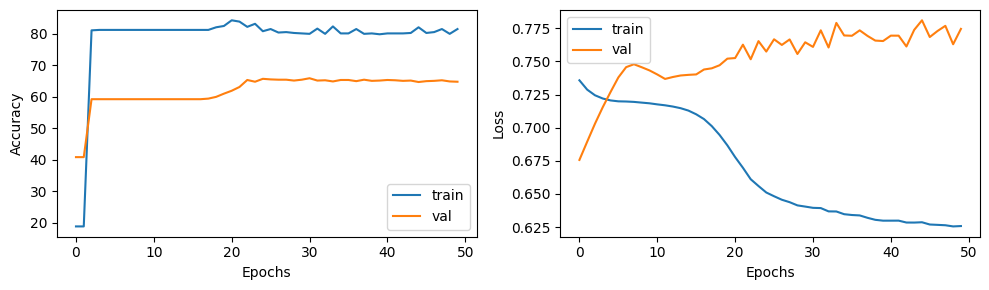

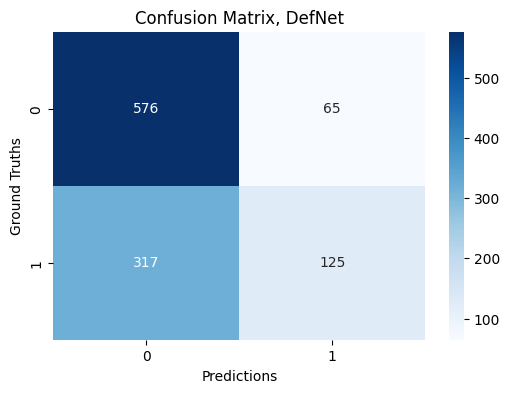

              precision    recall  f1-score   support

           0       0.65      0.90      0.75       641
           1       0.66      0.28      0.40       442

    accuracy                           0.65      1083
   macro avg       0.65      0.59      0.57      1083
weighted avg       0.65      0.65      0.61      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\inacc_t_models'
model_name= '16_8_inacc_t'

training_history, validation_history = net_trainer(small_net, optimizer,
                                             criterion, device, inacc_t_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)



Tau Threshold

In [ ]:
model_path = fr'.\nets\compas\iter_{iter}\inacc_t_models\16_8_inacc_t_model_50.pt' 

small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.63
0.6957142857142857


##### Net 2: 32/16

tau 0.61

In [ ]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping
set_all_seeds(42)


large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.21)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(),
                       lr=0.007,  #accettabile solo nell intervallo [0.005 a 0.007]
                       weight_decay= 1e-2
                    )

weights = torch.tensor([1.0, 3.0]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5) 


Training

Training Results - Epoch[1] Avg accuracy: 0.19 Avg loss: 0.73
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 1: Learning Rate 0.007
Training Results - Epoch[2] Avg accuracy: 0.81 Avg loss: 0.72
Validation Results - Epoch[2] Avg accuracy: 0.59 Avg loss: 0.73
End of Epoch 2: Learning Rate 0.007
Training Results - Epoch[3] Avg accuracy: 0.81 Avg loss: 0.72
Validation Results - Epoch[3] Avg accuracy: 0.59 Avg loss: 0.75
End of Epoch 3: Learning Rate 0.007
Training Results - Epoch[4] Avg accuracy: 0.81 Avg loss: 0.72
Validation Results - Epoch[4] Avg accuracy: 0.59 Avg loss: 0.75
End of Epoch 4: Learning Rate 0.007
Training Results - Epoch[5] Avg accuracy: 0.81 Avg loss: 0.72
Validation Results - Epoch[5] Avg accuracy: 0.59 Avg loss: 0.74
End of Epoch 5: Learning Rate 0.007
Training Results - Epoch[6] Avg accuracy: 0.81 Avg loss: 0.71
Validation Results - Epoch[6] Avg accuracy: 0.59 Avg loss: 0.74
End of Epoch 6: Learning Rate 0.007
Training Results - Epoch[7] 

2026-02-20 13:51:03,688 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[49] Avg accuracy: 0.79 Avg loss: 0.63
Validation Results - Epoch[49] Avg accuracy: 0.65 Avg loss: 0.75
End of Epoch 49: Learning Rate 0.000875


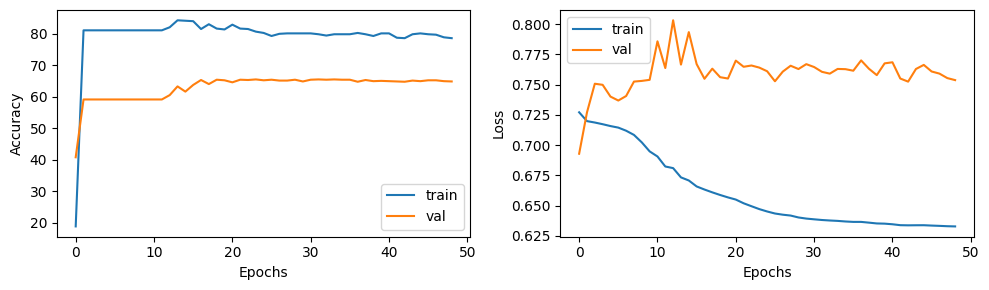

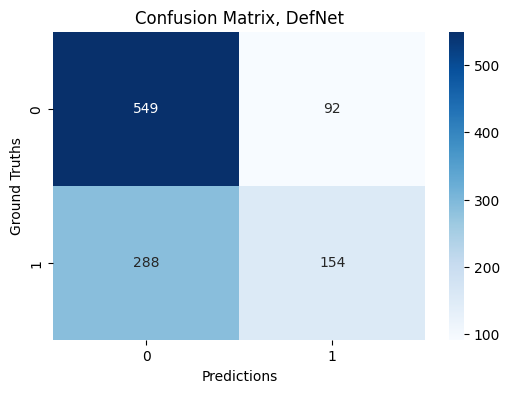

              precision    recall  f1-score   support

           0       0.66      0.86      0.74       641
           1       0.63      0.35      0.45       442

    accuracy                           0.65      1083
   macro avg       0.64      0.60      0.60      1083
weighted avg       0.64      0.65      0.62      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\inacc_t_models'
model_name= '32_16_inacc_t'

training_history, validation_history = net_trainer(large_net, optimizer,
                                             criterion, device, inacc_t_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)


Tau Threshold

In [ ]:
# dopo avere scelto la net migliore

model_path = fr'.\nets\compas\iter_3\inacc_t_models\32_16_inacc_t_model_49.pt'
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.61
0.7001499250374813


#### Deferral Strat 2 

tau             acc           def rate

29  0.436735       0.902954       0.279887

30  0.444898       0.897328       0.254571

31  0.453061       0.893108       0.229255

In [ ]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_inacc_t.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [ ]:
# sulla base di x_def chiamo la rete 

set_all_seeds(42)
r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff= 0.2)


optimizer = torch.optim.Adam(r_net.parameters(), lr=6e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
save_dir = fr'.\r_nets\compas\iter_{iter}'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(30):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/30 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_inacc_t.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/30 - Loss: 0.7452
Epoch 2/30 - Loss: 0.7199
Epoch 3/30 - Loss: 0.7232
Epoch 4/30 - Loss: 0.7258
Epoch 5/30 - Loss: 0.7274
Epoch 6/30 - Loss: 0.7242
Epoch 7/30 - Loss: 0.7169
Epoch 8/30 - Loss: 0.7186
Epoch 9/30 - Loss: 0.7228
Epoch 10/30 - Loss: 0.7193
Epoch 11/30 - Loss: 0.7106
Epoch 12/30 - Loss: 0.7084
Epoch 13/30 - Loss: 0.7189
Epoch 14/30 - Loss: 0.7203
Epoch 15/30 - Loss: 0.7166
Epoch 16/30 - Loss: 0.7139
Epoch 17/30 - Loss: 0.7075
Epoch 18/30 - Loss: 0.7098
Epoch 19/30 - Loss: 0.7225
Epoch 20/30 - Loss: 0.7066
Epoch 21/30 - Loss: 0.7070
Epoch 22/30 - Loss: 0.7084
Epoch 23/30 - Loss: 0.7138
Epoch 24/30 - Loss: 0.7048
Epoch 25/30 - Loss: 0.7078
Epoch 26/30 - Loss: 0.7102
Epoch 27/30 - Loss: 0.7080
Epoch 28/30 - Loss: 0.7100
Epoch 29/30 - Loss: 0.7102
Epoch 30/30 - Loss: 0.7073
✅ r_net salvata correttamente in .\r_nets\compas\iter_3


In [ ]:
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.3)

net_path= fr".\nets\compas\iter_{iter}\inacc_t_models\32_16_inacc_t_model_49.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)
large_net.eval()

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.2, 0.6, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.200000       1.000000       1.000000
1   0.208163       1.000000       1.000000
2   0.216327       1.000000       1.000000
3   0.224490       1.000000       1.000000
4   0.232653       1.000000       1.000000
5   0.240816       1.000000       0.997187
6   0.248980       1.000000       0.994374
7   0.257143       1.000000       0.990155
8   0.265306       1.000000       0.988748
9   0.273469       1.000000       0.987342
10  0.281633       1.000000       0.981716
11  0.289796       1.000000       0.976090
12  0.297959       0.998594       0.971871
13  0.306122       0.997187       0.966245
14  0.314286       0.997187       0.950774
15  0.322449       0.995781       0.946554
16  0.330612       0.990155       0.918425
17  0.338776       0.990155       0.891702
18  0.346939       0.988748       0.863572
19  0.355102       0.981716       0.828411
20  0.363265       0.976090       0.762307
21  0.371429       0.973277       0.680731
22  0.37959

## Expert: Accurate, Not Trusting

### Iter 1

In [ ]:
# retrieving the calibration split 

iter=1
df_val= pd.read_csv(r"processed_data\compas\calibration_datasets\iter_1\acc_nt_calibration.csv")

# retrieving data

df_acc_nt = pd.read_csv(r"processed_data\compas\hic_results_ds\iter_1\hic_accurate_not_trusting.csv")

path= f".\processed_data\compas\switch_ds\iter_{iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"acc_nt_switch.csv")

df_acc_nt.to_csv(file_path, index=False)

In [ ]:
feat_order = [c for c in df_acc_nt.columns if c not in [
    'did_recid', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction']]

X_cal, y_cal, acc_nt_loader = create_loader(df_acc_nt, feat_order, 'did_recid', batch_size=128, shuffle=False)

X_val, y_val, val_loader = create_loader(df_val, feat_order, 'did_recid', batch_size=128, shuffle=False)

#### Deferral Strat 1

chosen_ 32/16 net


##### Net 1: 16/8

tau= 0.54


In [ ]:
# Log:

# at the first trial, 
# with configuration (dropout_coeff=0.05, lr=0.001, weight_decay=1e-5, weights [1.0, 1.0], smoothing= 0.005, stepsize= 15, gamma= 0.8)
# both loss curves behaved very well, converging at the 0.65 loss wall
# overall accuracy was 0.63, however the signal from the user caused the net to achieve precision 62/69 and recall 95/16
# hence, just like the accurate, trusting user, the weights must be tweaked


# a 1.5 weight for class 1 caused collapsing over class 1
set_all_seeds(42)

small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.05)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(),
                       lr=0.001,
                       weight_decay=1e-5

                    )


weights = torch.tensor([1.0, 1.32]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.0)
scheduler = StepLR(optimizer, step_size=20, gamma=0.8) 


Training Results - Epoch[1] Avg accuracy: 0.43 Avg loss: 0.70
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.43 Avg loss: 0.70
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.43 Avg loss: 0.70
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.43 Avg loss: 0.70
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.43 Avg loss: 0.70
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.43 Avg loss: 0.70
Validation Results - Epoch[6] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

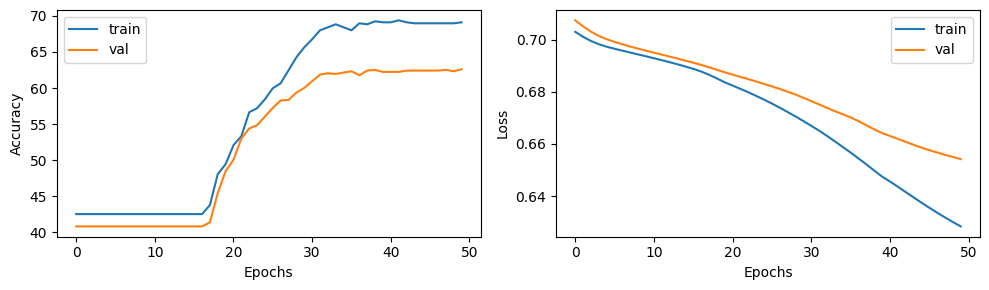

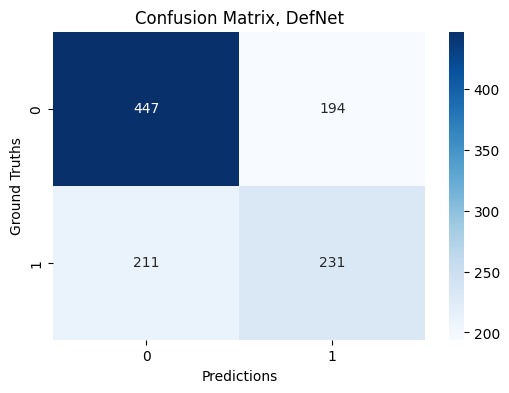

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       641
           1       0.54      0.52      0.53       442

    accuracy                           0.63      1083
   macro avg       0.61      0.61      0.61      1083
weighted avg       0.62      0.63      0.62      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\acc_nt_models'
model_name= '16_8_acc_nt'

training_history, validation_history = net_trainer(small_net, optimizer,
                                             criterion, device, acc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)



Tau Threshold

In [ ]:
model_path = fr'.\nets\compas\iter_{iter}\acc_nt_models\16_8_acc_nt_model_50.pt' 
small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.54
0.678082191780822


##### Net 2: 32/16

tau= 0.62

lo stesso valore di tau dell'altro user accurato peraltro

In [ ]:
# Log config changes:
# this one behaved really well, as expected from the other accurate users results 

# dropout fixed from 0.10 to 0.15 to keep the validation loss perfectly convex 
set_all_seeds(42)

large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.15)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(),
                       lr=0.0015,
                       weight_decay= 2e-4

                    )

weights = torch.tensor([1.0, 1.35]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.0)
scheduler = StepLR(optimizer, step_size=20, gamma=0.8) 


Training

Training Results - Epoch[1] Avg accuracy: 0.43 Avg loss: 0.69
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 1: Learning Rate 0.0015
Training Results - Epoch[2] Avg accuracy: 0.43 Avg loss: 0.69
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 2: Learning Rate 0.0015
Training Results - Epoch[3] Avg accuracy: 0.43 Avg loss: 0.69
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 3: Learning Rate 0.0015
Training Results - Epoch[4] Avg accuracy: 0.57 Avg loss: 0.69
Validation Results - Epoch[4] Avg accuracy: 0.53 Avg loss: 0.69
End of Epoch 4: Learning Rate 0.0015
Training Results - Epoch[5] Avg accuracy: 0.66 Avg loss: 0.68
Validation Results - Epoch[5] Avg accuracy: 0.62 Avg loss: 0.69
End of Epoch 5: Learning Rate 0.0015
Training Results - Epoch[6] Avg accuracy: 0.69 Avg loss: 0.68
Validation Results - Epoch[6] Avg accuracy: 0.64 Avg loss: 0.68
End of Epoch 6: Learning Rate 0.0015
Training Results - Epo

2026-02-20 20:41:56,992 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[35] Avg accuracy: 0.68 Avg loss: 0.60
Validation Results - Epoch[35] Avg accuracy: 0.63 Avg loss: 0.64
End of Epoch 35: Learning Rate 0.0012000000000000001
Training Results - Epoch[36] Avg accuracy: 0.68 Avg loss: 0.60
Validation Results - Epoch[36] Avg accuracy: 0.63 Avg loss: 0.64
End of Epoch 36: Learning Rate 0.0012000000000000001
Training Results - Epoch[37] Avg accuracy: 0.68 Avg loss: 0.60
Validation Results - Epoch[37] Avg accuracy: 0.63 Avg loss: 0.64
End of Epoch 37: Learning Rate 0.0012000000000000001


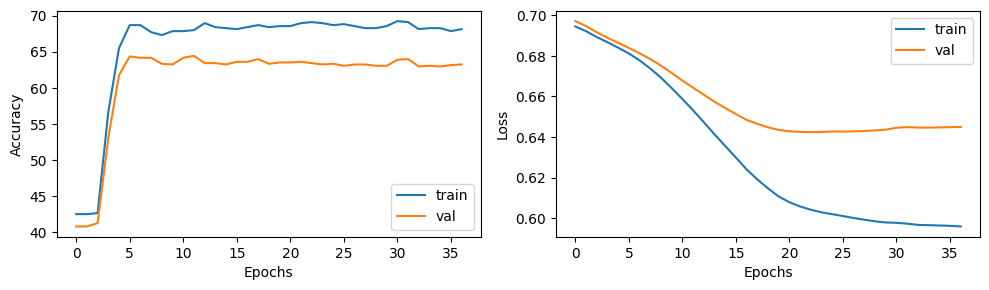

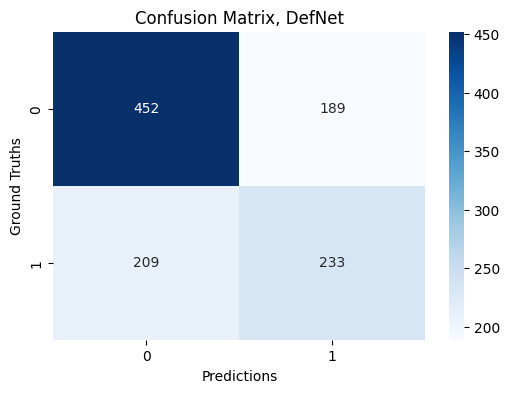

              precision    recall  f1-score   support

           0       0.68      0.71      0.69       641
           1       0.55      0.53      0.54       442

    accuracy                           0.63      1083
   macro avg       0.62      0.62      0.62      1083
weighted avg       0.63      0.63      0.63      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\acc_nt_models'
model_name= '32_16_acc_nt'

training_history, validation_history = net_trainer(large_net, optimizer,
                                             criterion, device, acc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)


Tau Threshold

In [ ]:
# dopo avere scelto la net migliore

model_path = fr'nets\compas\iter_{iter}\acc_nt_models\32_16_acc_nt_model_37.pt' 
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.62
0.6875957120980092


#### Deferral Strat 2 


    thresh          acc           defer rate

11  0.193220       0.761773       0.259003

12  0.201695       0.738227       0.174515 <--- this one deferred 34% on real data

13  0.210169       0.722992       0.120499 

14  0.218644       0.700831       0.078947 <--- this one defers 25% on real data

15  0.227119       0.693906       0.044321 <--- this defers 22%

16  0.235593       0.689751       0.023546

17  0.244068       0.684211       0.009695 <--- chosen

18  0.252542       0.682825       0.004155 <--- 10% def rate

19  0.261017       0.682825       0.001385





  
  

In [ ]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_acc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [ ]:
# sulla base di x_def chiamo la rete 
set_all_seeds(42)
r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff= 0.1)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


save_dir = fr'.\r_nets\compas\iter_{iter}'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_acc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/20 - Loss: 0.5449
Epoch 2/20 - Loss: 0.5312
Epoch 3/20 - Loss: 0.4973
Epoch 4/20 - Loss: 0.4610
Epoch 5/20 - Loss: 0.4202
Epoch 6/20 - Loss: 0.3844
Epoch 7/20 - Loss: 0.3516
Epoch 8/20 - Loss: 0.3412
Epoch 9/20 - Loss: 0.3415
Epoch 10/20 - Loss: 0.3406
Epoch 11/20 - Loss: 0.3362
Epoch 12/20 - Loss: 0.3410
Epoch 13/20 - Loss: 0.3420
Epoch 14/20 - Loss: 0.3444
Epoch 15/20 - Loss: 0.3371
Epoch 16/20 - Loss: 0.3372
Epoch 17/20 - Loss: 0.3385
Epoch 18/20 - Loss: 0.3364
Epoch 19/20 - Loss: 0.3390
Epoch 20/20 - Loss: 0.3349
✅ r_net salvata correttamente in .\r_nets\compas\iter_1


In [ ]:
set_all_seeds(42)


p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.0)

net_path= fr".\nets\compas\iter_{iter}\acc_nt_models\32_16_acc_nt_model_37.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.1, 0.6, 60) # ofc adjusted the zooming only to interesting areas of the search
calibration_results = []

for tr in thresholds:
    
    defer_mask = (p_defer_calib >= tr)
    
    # accuracy custom, applichi mask + fetch correct
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.100000       1.000000       1.000000
1   0.108475       1.000000       1.000000
2   0.116949       1.000000       1.000000
3   0.125424       1.000000       1.000000
4   0.133898       0.997230       0.990305
5   0.142373       0.983380       0.950139
6   0.150847       0.959834       0.854571
7   0.159322       0.900277       0.706371
8   0.167797       0.862881       0.591413
9   0.176271       0.821330       0.459834
10  0.184746       0.788089       0.350416
11  0.193220       0.761773       0.259003
12  0.201695       0.738227       0.174515
13  0.210169       0.722992       0.120499
14  0.218644       0.700831       0.078947
15  0.227119       0.693906       0.044321
16  0.235593       0.689751       0.023546
17  0.244068       0.684211       0.009695
18  0.252542       0.682825       0.004155
19  0.261017       0.682825       0.001385
20  0.269492       0.681440       0.000000
21  0.277966       0.681440       0.000000
22  0.28644

### Iter 2

In [ ]:
# retrieving the calibration split 
iter=2

df_val= pd.read_csv(fr".\processed_data\compas\calibration_datasets\iter_{iter}\acc_nt_calibration.csv")

df_acc_nt = pd.read_csv(fr"processed_data\compas\hic_results_ds\iter_{iter}\hic_accurate_not_trusting.csv")

path= f".\processed_data\compas\switch_ds\iter_{iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"acc_nt_switch.csv")

df_acc_nt.to_csv(file_path, index=False)

In [ ]:
feat_order = [c for c in df_acc_nt.columns if c not in [
    'did_recid', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction']]

X_cal, y_cal, acc_nt_loader = create_loader(df_acc_nt, feat_order, 'did_recid', batch_size=128, shuffle=False)

X_val, y_val, val_loader = create_loader(df_val, feat_order, 'did_recid', batch_size=128, shuffle=False)

#### Deferral Strat 1


##### Net 1: 16/8

tau= 0.62


In [ ]:
# Log config changes:

# questa rete non ha neanche bisogno di label smoothing nè peso in più alla classe 1, produce risultati discreti

set_all_seeds(42)

small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.05)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(),
                       lr=0.001,
                       weight_decay=1e-5

                    )


weights = torch.tensor([1.0, 1.0]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.00)
scheduler = StepLR(optimizer, step_size=20, gamma=0.8) 


Training

Training Results - Epoch[1] Avg accuracy: 0.49 Avg loss: 0.71
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.73
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.49 Avg loss: 0.70
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.49 Avg loss: 0.70
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.49 Avg loss: 0.70
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.49 Avg loss: 0.70
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.49 Avg loss: 0.70
Validation Results - Epoch[6] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

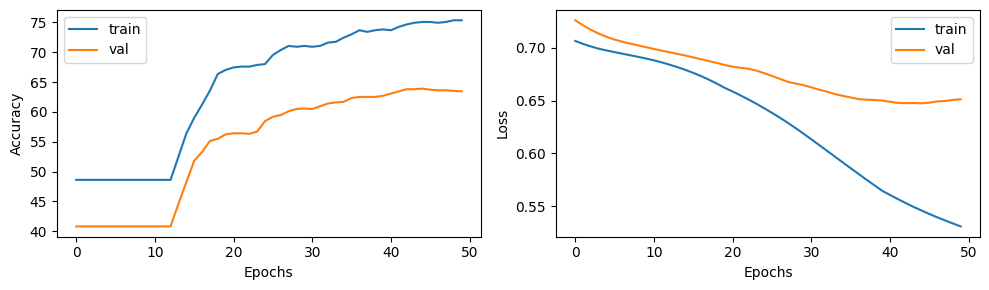

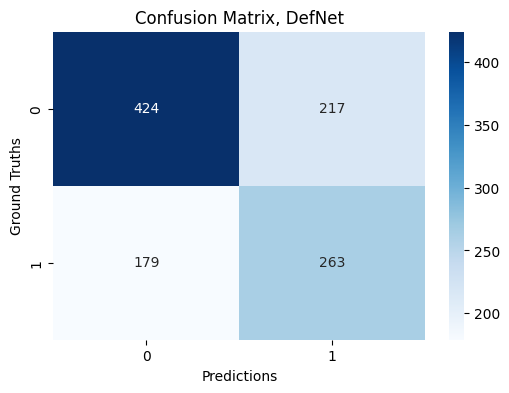

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       641
           1       0.55      0.60      0.57       442

    accuracy                           0.63      1083
   macro avg       0.63      0.63      0.63      1083
weighted avg       0.64      0.63      0.64      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\acc_nt_models'
model_name= '16_8_acc_nt'

training_history, validation_history = net_trainer(small_net, optimizer,
                                             criterion, device, acc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)



Tau Threshold

In [ ]:
model_path = fr'.\nets\compas\iter_{iter}\acc_nt_models\16_8_acc_nt_model_50.pt' 

small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.62
0.6701183431952663


##### Net 2: 32/16

tau 0.59

In [ ]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping
set_all_seeds(42)

large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.2)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(),
                       lr=0.001,
                       weight_decay= 1e-2

                    )

weights = torch.tensor([1.0, 1.0]).to(device) #1.1 troppo basso
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.00)
scheduler = StepLR(optimizer, step_size=18, gamma=0.8) 


Training

Training Results - Epoch[1] Avg accuracy: 0.49 Avg loss: 0.69
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.49 Avg loss: 0.69
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.51 Avg loss: 0.69
Validation Results - Epoch[3] Avg accuracy: 0.43 Avg loss: 0.69
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.57 Avg loss: 0.69
Validation Results - Epoch[4] Avg accuracy: 0.50 Avg loss: 0.69
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.61 Avg loss: 0.69
Validation Results - Epoch[5] Avg accuracy: 0.56 Avg loss: 0.69
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.70 Avg loss: 0.69
Validation Results - Epoch[6] Avg accuracy: 0.61 Avg loss: 0.69
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

2026-02-20 21:19:37,408 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[30] Avg accuracy: 0.76 Avg loss: 0.59
Validation Results - Epoch[30] Avg accuracy: 0.63 Avg loss: 0.64
End of Epoch 30: Learning Rate 0.0008
Training Results - Epoch[31] Avg accuracy: 0.75 Avg loss: 0.58
Validation Results - Epoch[31] Avg accuracy: 0.63 Avg loss: 0.64
End of Epoch 31: Learning Rate 0.0008
Training Results - Epoch[32] Avg accuracy: 0.75 Avg loss: 0.57
Validation Results - Epoch[32] Avg accuracy: 0.64 Avg loss: 0.64
End of Epoch 32: Learning Rate 0.0008
Training Results - Epoch[33] Avg accuracy: 0.76 Avg loss: 0.57
Validation Results - Epoch[33] Avg accuracy: 0.63 Avg loss: 0.64
End of Epoch 33: Learning Rate 0.0008
Epoch[34], Iter[200] Loss: 0.57
Training Results - Epoch[34] Avg accuracy: 0.76 Avg loss: 0.56
Validation Results - Epoch[34] Avg accuracy: 0.64 Avg loss: 0.64
End of Epoch 34: Learning Rate 0.0008


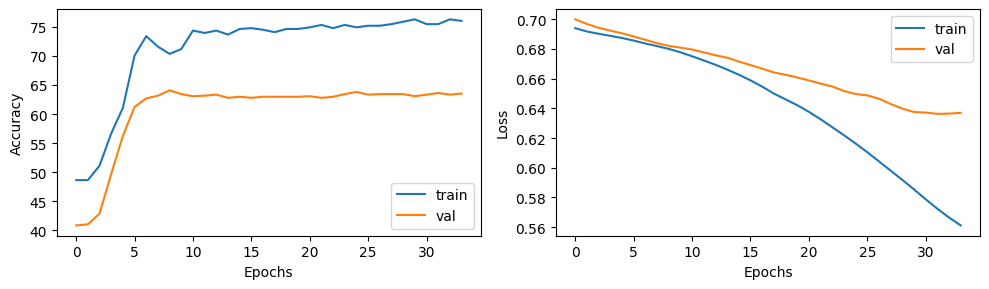

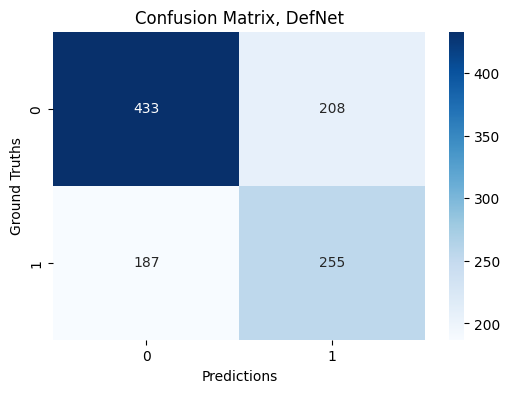

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       641
           1       0.55      0.58      0.56       442

    accuracy                           0.64      1083
   macro avg       0.62      0.63      0.63      1083
weighted avg       0.64      0.64      0.64      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\acc_nt_models'
model_name= '32_16_acc_nt'

training_history, validation_history = net_trainer(large_net, optimizer,
                                             criterion, device, acc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)


Tau Threshold

In [ ]:
# dopo avere scelto la net migliore

model_path = fr'.\nets\compas\iter_2\acc_nt_models\32_16_acc_nt_model_34.pt'
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.59
0.680119581464873


#### Deferral Strat 2 

    tau             acc          defer rate
19  0.216327       0.818560       0.222992 <-- 12%

20  0.222449       0.801939       0.162050 <-- 8%

21  0.228571       0.789474       0.121884

22  0.234694       0.785319       0.094183

23  0.240816       0.781163       0.070637  <-- this produces 2% defer rate

24  0.246939       0.775623       0.051247

In [ ]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_acc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [ ]:
# sulla base di x_def chiamo la rete 

set_all_seeds(42)
r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff= 0.18)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
save_dir = fr'.\r_nets\compas\iter_{iter}'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(30):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/30 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_acc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/30 - Loss: 0.6086
Epoch 2/30 - Loss: 0.5955
Epoch 3/30 - Loss: 0.5820
Epoch 4/30 - Loss: 0.5720
Epoch 5/30 - Loss: 0.5599
Epoch 6/30 - Loss: 0.5408
Epoch 7/30 - Loss: 0.5217
Epoch 8/30 - Loss: 0.5029
Epoch 9/30 - Loss: 0.4799
Epoch 10/30 - Loss: 0.4564
Epoch 11/30 - Loss: 0.4365
Epoch 12/30 - Loss: 0.4189
Epoch 13/30 - Loss: 0.4076
Epoch 14/30 - Loss: 0.4066
Epoch 15/30 - Loss: 0.4024
Epoch 16/30 - Loss: 0.4012
Epoch 17/30 - Loss: 0.4072
Epoch 18/30 - Loss: 0.4013
Epoch 19/30 - Loss: 0.3990
Epoch 20/30 - Loss: 0.3994
Epoch 21/30 - Loss: 0.3990
Epoch 22/30 - Loss: 0.4008
Epoch 23/30 - Loss: 0.3978
Epoch 24/30 - Loss: 0.3909
Epoch 25/30 - Loss: 0.3958
Epoch 26/30 - Loss: 0.4000
Epoch 27/30 - Loss: 0.3952
Epoch 28/30 - Loss: 0.3898
Epoch 29/30 - Loss: 0.3984
Epoch 30/30 - Loss: 0.3906
✅ r_net salvata correttamente in .\r_nets\compas\iter_2


In [ ]:
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.3)

net_path= fr".\nets\compas\iter_{iter}\acc_nt_models\32_16_acc_nt_model_34.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)
large_net.eval()

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.1, 0.4, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.100000       1.000000       1.000000
1   0.106122       1.000000       1.000000
2   0.112245       1.000000       1.000000
3   0.118367       1.000000       1.000000
4   0.124490       1.000000       1.000000
5   0.130612       1.000000       1.000000
6   0.136735       1.000000       1.000000
7   0.142857       1.000000       1.000000
8   0.148980       1.000000       1.000000
9   0.155102       1.000000       0.995845
10  0.161224       0.997230       0.981994
11  0.167347       0.995845       0.972299
12  0.173469       0.984765       0.926593
13  0.179592       0.961219       0.851801
14  0.185714       0.934903       0.754848
15  0.191837       0.918283       0.646814
16  0.197959       0.882271       0.501385
17  0.204082       0.854571       0.390582
18  0.210204       0.833795       0.288089
19  0.216327       0.818560       0.222992
20  0.222449       0.801939       0.162050
21  0.228571       0.789474       0.121884
22  0.23469

### Iter 3

In [ ]:
# retrieving the calibration split 
iter=3

df_val= pd.read_csv(fr".\processed_data\compas\calibration_datasets\iter_{iter}\acc_nt_calibration.csv")

df_acc_nt = pd.read_csv(fr"processed_data\compas\hic_results_ds\iter_{iter}\hic_accurate_not_trusting.csv")

path= f".\processed_data\compas\switch_ds\iter_{iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"acc_nt_switch.csv")

df_acc_nt.to_csv(file_path, index=False)

In [ ]:
feat_order = [c for c in df_acc_nt.columns if c not in [
    'did_recid', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction']]

X_cal, y_cal, acc_nt_loader = create_loader(df_acc_nt, feat_order, 'did_recid', batch_size=128, shuffle=False)

X_val, y_val, val_loader = create_loader(df_val, feat_order, 'did_recid', batch_size=128, shuffle=False)

#### Deferral Strat 1


##### Net 1: 16/8

tau= 0.57


In [ ]:
# Log config changes:
# this one doesnt need smoothing nor weight to class 1
# even with no dropout it behaves well
# noticeably tho, it cant go beyound 0.66, its just like the others
set_all_seeds(42)

small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.0)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(),
                       lr=0.001,
                       weight_decay=1e-5

                    )


weights = torch.tensor([1.0, 1.0]).to(device) 
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.00)
scheduler = StepLR(optimizer, step_size=20, gamma=0.8) 


Training

Training Results - Epoch[1] Avg accuracy: 0.52 Avg loss: 0.70
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.73
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.52 Avg loss: 0.70
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.73
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.52 Avg loss: 0.70
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[6] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

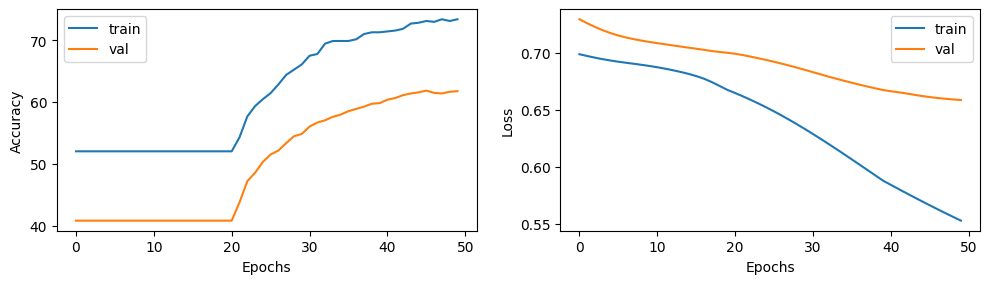

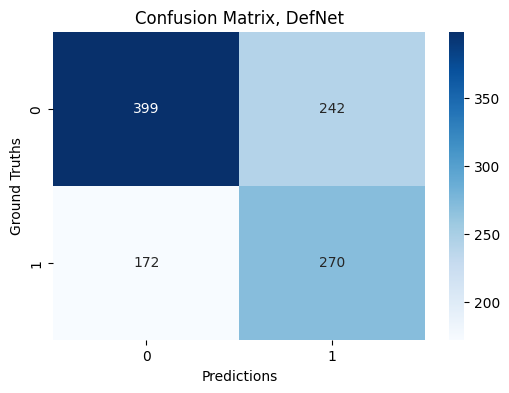

              precision    recall  f1-score   support

           0       0.70      0.62      0.66       641
           1       0.53      0.61      0.57       442

    accuracy                           0.62      1083
   macro avg       0.61      0.62      0.61      1083
weighted avg       0.63      0.62      0.62      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\acc_nt_models'
model_name= '16_8_acc_nt'

training_history, validation_history = net_trainer(small_net, optimizer,
                                             criterion, device, acc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)



Tau Threshold

In [ ]:
model_path = fr'.\nets\compas\iter_{iter}\acc_nt_models\16_8_acc_nt_model_50.pt' 

small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.5700000000000001
0.6614285714285715


##### Net 2: 32/16

tau 0.6

In [ ]:

set_all_seeds(42)

large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.2)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(),
                       lr=0.001,
                       weight_decay= 1e-2

                    )

weights = torch.tensor([1.0, 1.0]).to(device) #1.1 troppo basso
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.00)
scheduler = StepLR(optimizer, step_size=18, gamma=0.8) 

Training

Training Results - Epoch[1] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[6] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

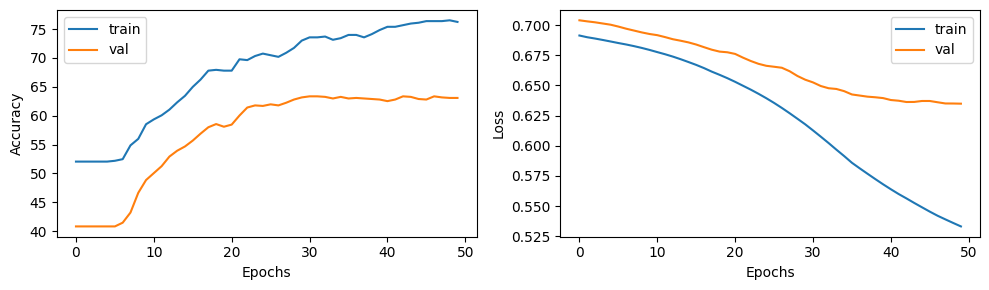

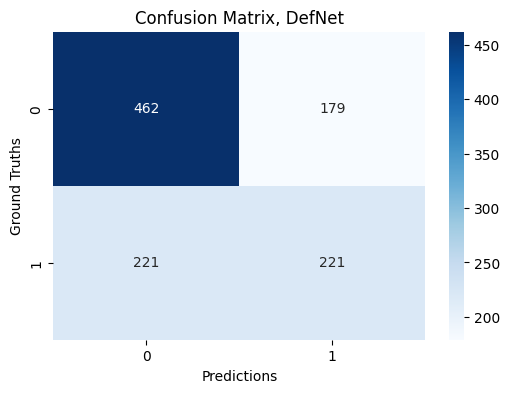

              precision    recall  f1-score   support

           0       0.68      0.72      0.70       641
           1       0.55      0.50      0.52       442

    accuracy                           0.63      1083
   macro avg       0.61      0.61      0.61      1083
weighted avg       0.63      0.63      0.63      1083



In [ ]:
save_dir= fr'.\nets\compas\iter_{iter}\acc_nt_models'
model_name= '32_16_acc_nt'

training_history, validation_history = net_trainer(large_net, optimizer,
                                             criterion, device, acc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)


Tau Threshold

In [ ]:
# dopo avere scelto la net migliore

model_path = fr'.\nets\compas\iter_3\acc_nt_models\32_16_acc_nt_model_50.pt'
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.6
0.6901615271659325


#### Deferral Strat 2 

    tau             acc           def rate

15  0.222449       0.801688       0.163150

16  0.230612       0.784810       0.091421 <--- 

17  0.238776       0.776371       0.050633

In [ ]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_acc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [ ]:
# sulla base di x_def chiamo la rete 
# same configuration as iter 2
set_all_seeds(42)
r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff= 0.18)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
save_dir = fr'.\r_nets\compas\iter_{iter}'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(30):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/30 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_acc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/30 - Loss: 0.6233
Epoch 2/30 - Loss: 0.6170
Epoch 3/30 - Loss: 0.6042
Epoch 4/30 - Loss: 0.5887
Epoch 5/30 - Loss: 0.5704
Epoch 6/30 - Loss: 0.5578
Epoch 7/30 - Loss: 0.5374
Epoch 8/30 - Loss: 0.5095
Epoch 9/30 - Loss: 0.4928
Epoch 10/30 - Loss: 0.4669
Epoch 11/30 - Loss: 0.4561
Epoch 12/30 - Loss: 0.4261
Epoch 13/30 - Loss: 0.4176
Epoch 14/30 - Loss: 0.4168
Epoch 15/30 - Loss: 0.4125
Epoch 16/30 - Loss: 0.4107
Epoch 17/30 - Loss: 0.4135
Epoch 18/30 - Loss: 0.4186
Epoch 19/30 - Loss: 0.4056
Epoch 20/30 - Loss: 0.4103
Epoch 21/30 - Loss: 0.4113
Epoch 22/30 - Loss: 0.4072
Epoch 23/30 - Loss: 0.4075
Epoch 24/30 - Loss: 0.4077
Epoch 25/30 - Loss: 0.4093
Epoch 26/30 - Loss: 0.4063
Epoch 27/30 - Loss: 0.4039
Epoch 28/30 - Loss: 0.4108
Epoch 29/30 - Loss: 0.4099
Epoch 30/30 - Loss: 0.4030
✅ r_net salvata correttamente in .\r_nets\compas\iter_3


In [ ]:
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.3)

net_path= fr".\nets\compas\iter_{iter}\acc_nt_models\32_16_acc_nt_model_50.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)
large_net.eval()

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.1, 0.5, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.100000       1.000000       1.000000
1   0.108163       1.000000       1.000000
2   0.116327       1.000000       1.000000
3   0.124490       1.000000       1.000000
4   0.132653       1.000000       1.000000
5   0.140816       1.000000       1.000000
6   0.148980       1.000000       1.000000
7   0.157143       1.000000       1.000000
8   0.165306       0.998594       0.995781
9   0.173469       0.995781       0.974684
10  0.181633       0.971871       0.887482
11  0.189796       0.932489       0.690577
12  0.197959       0.901547       0.526020
13  0.206122       0.849508       0.361463
14  0.214286       0.821378       0.251758
15  0.222449       0.801688       0.163150
16  0.230612       0.784810       0.091421
17  0.238776       0.776371       0.050633
18  0.246939       0.769339       0.033755
19  0.255102       0.766526       0.019691
20  0.263265       0.765120       0.011252
21  0.271429       0.763713       0.007032
22  0.27959

## Expert: Inaccurate, Not Trusting

### Iter 1

In [22]:
# retrieving the calibration split 

iter=1
df_val= pd.read_csv(r"processed_data\compas\calibration_datasets\iter_1\inacc_nt_calibration.csv")

# retrieving data

df_inacc_nt = pd.read_csv(r"processed_data\compas\hic_results_ds\iter_1\hic_inaccurate_not_trusting.csv")

path= f".\processed_data\compas\switch_ds\iter_{iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"inacc_nt_switch.csv")

df_inacc_nt.to_csv(file_path, index=False)

In [23]:
feat_order = [c for c in df_inacc_nt.columns if c not in [
    'did_recid', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction']]

X_cal, y_cal, inacc_nt_loader = create_loader(df_inacc_nt, feat_order, 'did_recid', batch_size=128, shuffle=False)

X_val, y_val, val_loader = create_loader(df_val, feat_order, 'did_recid', batch_size=128, shuffle=False)

#### Deferral Strat 1

chosen_ 32/16 net


##### Net 1: 16/8

tau= 0.57


In [ ]:
# Log:
# not much to say here tbh, the nets didnt require any weight nor label smoothing, just a tiny bit of dropout and its ready to go
# what happened was that since this user is inaccurate, but not trusting the machine in HIC, the signal was not pollued too much
# ofc, on paper the results look decent, however the net is not decisive like the previous ones for class 0

set_all_seeds(42)

small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.05)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(),
                       lr=0.001,
                       weight_decay=1e-5

                    )


weights = torch.tensor([1.0, 1.0]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.0)
scheduler = StepLR(optimizer, step_size=20, gamma=0.8) 


Training Results - Epoch[1] Avg accuracy: 0.52 Avg loss: 0.70
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.74
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.52 Avg loss: 0.70
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.73
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.52 Avg loss: 0.70
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.73
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.52 Avg loss: 0.70
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.52 Avg loss: 0.70
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[6] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

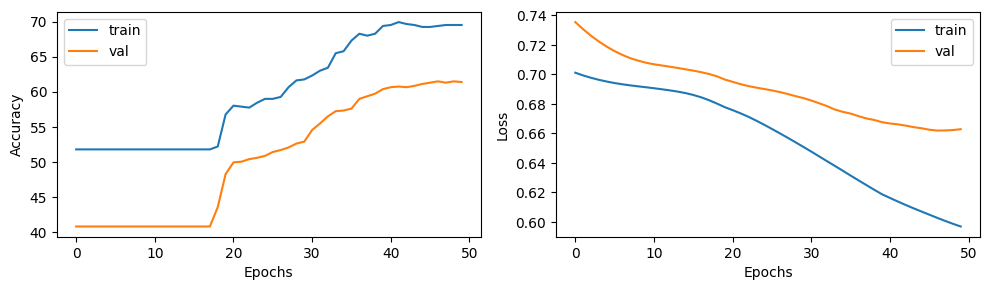

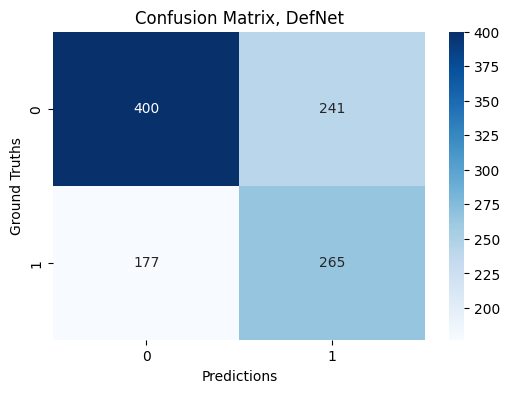

              precision    recall  f1-score   support

           0       0.69      0.62      0.66       641
           1       0.52      0.60      0.56       442

    accuracy                           0.61      1083
   macro avg       0.61      0.61      0.61      1083
weighted avg       0.62      0.61      0.62      1083



In [16]:
save_dir= fr'.\nets\compas\iter_{iter}\inacc_nt_models'
model_name= '16_8_inacc_nt'

training_history, validation_history = net_trainer(small_net, optimizer,
                                             criterion, device, inacc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)



Tau Threshold

In [17]:
model_path = fr'.\nets\compas\iter_{iter}\inacc_nt_models\16_8_inacc_nt_model_50.pt' 
small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.5700000000000001
0.6551724137931034


##### Net 2: 32/16

tau= 0.62

lo stesso valore di tau dell'altro user accurato peraltro

In [ ]:
# Log config changes:
# incredibly enough, this one didnt need weights too nor smoothing
# and its ofc more realistic than the 16/8
set_all_seeds(42)

large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.15)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(),
                       lr=0.0015,
                       weight_decay= 2e-4

                    )

weights = torch.tensor([1.0, 1.0]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.0)
scheduler = StepLR(optimizer, step_size=20, gamma=0.8) 


Training

Training Results - Epoch[1] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 1: Learning Rate 0.0015
Training Results - Epoch[2] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 2: Learning Rate 0.0015
Training Results - Epoch[3] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 3: Learning Rate 0.0015
Training Results - Epoch[4] Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 4: Learning Rate 0.0015
Training Results - Epoch[5] Avg accuracy: 0.53 Avg loss: 0.69
Validation Results - Epoch[5] Avg accuracy: 0.43 Avg loss: 0.70
End of Epoch 5: Learning Rate 0.0015
Training Results - Epoch[6] Avg accuracy: 0.57 Avg loss: 0.69
Validation Results - Epoch[6] Avg accuracy: 0.49 Avg loss: 0.70
End of Epoch 6: Learning Rate 0.0015
Training Results - Epo

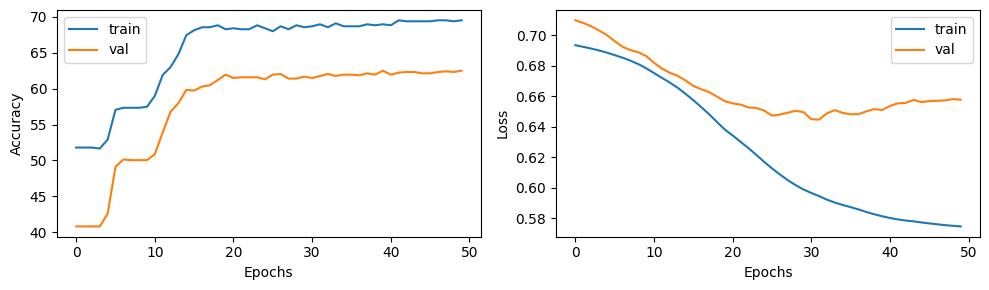

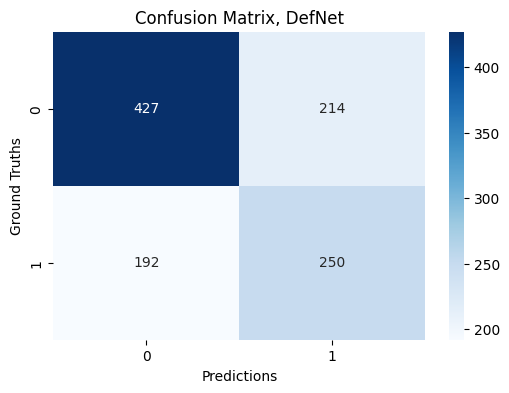

              precision    recall  f1-score   support

           0       0.69      0.67      0.68       641
           1       0.54      0.57      0.55       442

    accuracy                           0.63      1083
   macro avg       0.61      0.62      0.61      1083
weighted avg       0.63      0.63      0.63      1083



In [25]:
save_dir= fr'.\nets\compas\iter_{iter}\inacc_nt_models'
model_name= '32_16_inacc_nt'

training_history, validation_history = net_trainer(large_net, optimizer,
                                             criterion, device, inacc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)


Tau Threshold

In [26]:
# dopo avere scelto la net migliore

model_path = fr'nets\compas\iter_{iter}\inacc_nt_models\32_16_inacc_nt_model_50.pt' 
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.62
0.6676783004552352


#### Deferral Strat 2 


    thresh          acc           defer rate

23  0.216949       0.768698       0.224377

24  0.222034       0.745152       0.141274  <-- 8% defer

25  0.227119       0.724377       0.090028  <-- 3% defer 

26  0.232203       0.707756       0.042936



  
  

In [27]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_inacc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [28]:
# sulla base di x_def chiamo la rete 
set_all_seeds(42)
r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff= 0.1)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


save_dir = fr'.\r_nets\compas\iter_{iter}'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_inacc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/20 - Loss: 0.5703
Epoch 2/20 - Loss: 0.5538
Epoch 3/20 - Loss: 0.5302
Epoch 4/20 - Loss: 0.5154
Epoch 5/20 - Loss: 0.4879
Epoch 6/20 - Loss: 0.4500
Epoch 7/20 - Loss: 0.4126
Epoch 8/20 - Loss: 0.3861
Epoch 9/20 - Loss: 0.3802
Epoch 10/20 - Loss: 0.3731
Epoch 11/20 - Loss: 0.3839
Epoch 12/20 - Loss: 0.3773
Epoch 13/20 - Loss: 0.3756
Epoch 14/20 - Loss: 0.3774
Epoch 15/20 - Loss: 0.3829
Epoch 16/20 - Loss: 0.3744
Epoch 17/20 - Loss: 0.3724
Epoch 18/20 - Loss: 0.3739
Epoch 19/20 - Loss: 0.3793
Epoch 20/20 - Loss: 0.3697
✅ r_net salvata correttamente in .\r_nets\compas\iter_1


In [30]:
set_all_seeds(42)


p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.0)

net_path= fr".\nets\compas\iter_{iter}\inacc_nt_models\32_16_inacc_nt_model_50.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.1, 0.4, 60) # ofc adjusted the zooming only to interesting areas of the search
calibration_results = []

for tr in thresholds:
    
    defer_mask = (p_defer_calib >= tr)
    
    # accuracy custom, applichi mask + fetch correct
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.100000       1.000000       1.000000
1   0.105085       1.000000       1.000000
2   0.110169       1.000000       1.000000
3   0.115254       1.000000       0.998615
4   0.120339       1.000000       0.997230
5   0.125424       1.000000       0.997230
6   0.130508       1.000000       0.997230
7   0.135593       1.000000       0.997230
8   0.140678       1.000000       0.994460
9   0.145763       1.000000       0.994460
10  0.150847       1.000000       0.987535
11  0.155932       1.000000       0.987535
12  0.161017       1.000000       0.986150
13  0.166102       0.997230       0.979224
14  0.171186       0.994460       0.965374
15  0.176271       0.986150       0.948753
16  0.181356       0.968144       0.912742
17  0.186441       0.948753       0.847645
18  0.191525       0.930748       0.779778
19  0.196610       0.894737       0.671745
20  0.201695       0.857341       0.552632
21  0.206780       0.824100       0.430748
22  0.21186

### Iter 2

In [73]:
# retrieving the calibration split 
iter=2

df_val= pd.read_csv(fr".\processed_data\compas\calibration_datasets\iter_{iter}\inacc_nt_calibration.csv")

df_inacc_nt = pd.read_csv(fr"processed_data\compas\hic_results_ds\iter_{iter}\hic_inaccurate_not_trusting.csv")

path= f".\processed_data\compas\switch_ds\iter_{iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"inacc_nt_switch.csv")

df_inacc_nt.to_csv(file_path, index=False)

In [74]:
feat_order = [c for c in df_inacc_nt.columns if c not in [
    'did_recid', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction']]

X_cal, y_cal, inacc_nt_loader = create_loader(df_inacc_nt, feat_order, 'did_recid', batch_size=128, shuffle=False)

X_val, y_val, val_loader = create_loader(df_val, feat_order, 'did_recid', batch_size=128, shuffle=False)

#### Deferral Strat 1


##### Net 1: 16/8

tau= 0.61


In [ ]:
# Log config changes:

# ok in this setting i actually had to weigh up the majority class
# the res highlights the negative feedback the inaccurate, not trusting user is providing the net
# the most aggravating of the two is probably not trusting HiC

set_all_seeds(42)

small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.05)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(),
                       lr=0.001,
                       weight_decay=1e-5

                    )


weights = torch.tensor([1.8, 1.0]).to(device) # 3.0 troppo
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.00)
scheduler = StepLR(optimizer, step_size=20, gamma=0.8) 


Training

Training Results - Epoch[1] Avg accuracy: 0.63 Avg loss: 0.71
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.78
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.63 Avg loss: 0.71
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.77
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.63 Avg loss: 0.70
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.76
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.63 Avg loss: 0.70
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.75
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.63 Avg loss: 0.70
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.74
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.63 Avg loss: 0.70
Validation Results - Epoch[6] Avg accuracy: 0.41 Avg loss: 0.74
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

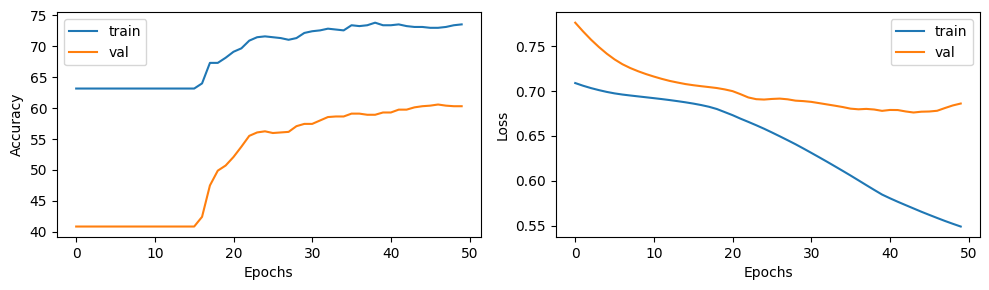

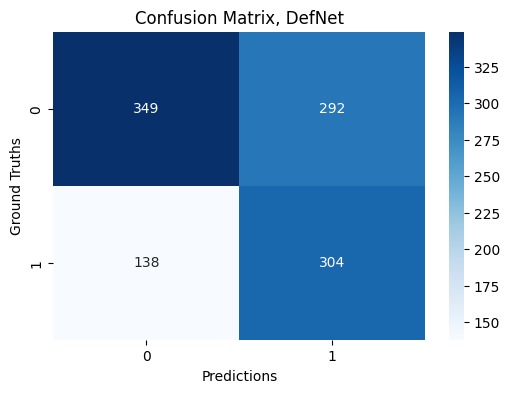

              precision    recall  f1-score   support

           0       0.72      0.54      0.62       641
           1       0.51      0.69      0.59       442

    accuracy                           0.60      1083
   macro avg       0.61      0.62      0.60      1083
weighted avg       0.63      0.60      0.61      1083



In [39]:
save_dir= fr'.\nets\compas\iter_{iter}\inacc_nt_models'
model_name= '16_8_inacc_nt'

training_history, validation_history = net_trainer(small_net, optimizer,
                                             criterion, device, inacc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)



Tau Threshold

In [40]:
model_path = fr'.\nets\compas\iter_{iter}\inacc_nt_models\16_8_inacc_nt_model_50.pt' 

small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.61
0.6359516616314199


##### Net 2: 32/16

tau 0.58

In [75]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping
# reduced dropout 0.20 to 0.18, then to 0.12 ---> 0.14 --> 0.18 was the best

# the picture painted here is clearly more realistic wrt to the 16/8. 
# at least i didnt have to tune up the weight to 1.8 for class 0. even 1.55 was fine
set_all_seeds(42)

large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.18)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(),
                       lr=0.001,
                       weight_decay= 1e-2

                    )

weights = torch.tensor([1.6, 1.0]).to(device) #tried 1.8, 1.5 (just a lil bit low)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.00)
scheduler = StepLR(optimizer, step_size=18, gamma=0.8) 


Training

Training Results - Epoch[1] Avg accuracy: 0.63 Avg loss: 0.69
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.73
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.63 Avg loss: 0.69
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.63 Avg loss: 0.69
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.63 Avg loss: 0.69
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.63 Avg loss: 0.69
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.63 Avg loss: 0.69
Validation Results - Epoch[6] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

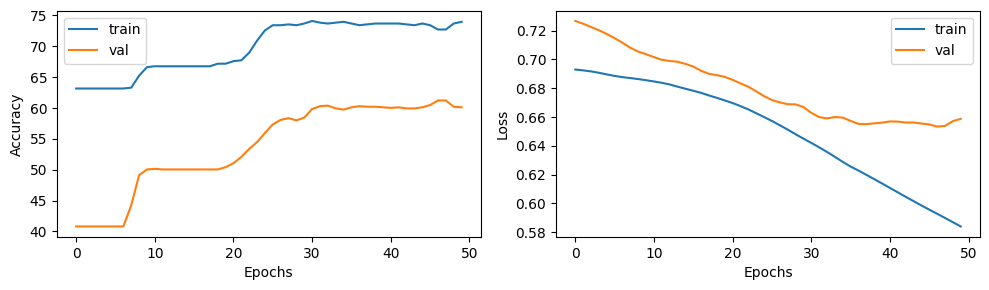

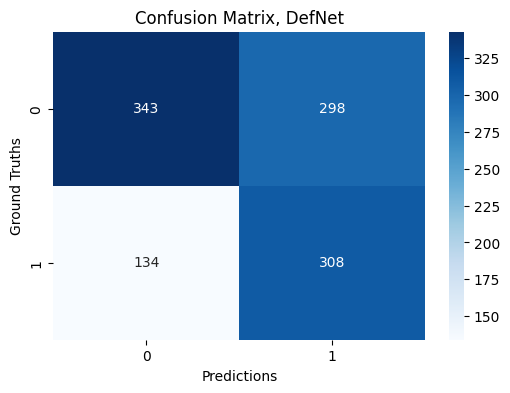

              precision    recall  f1-score   support

           0       0.72      0.54      0.61       641
           1       0.51      0.70      0.59       442

    accuracy                           0.60      1083
   macro avg       0.61      0.62      0.60      1083
weighted avg       0.63      0.60      0.60      1083



In [76]:
save_dir= fr'.\nets\compas\iter_{iter}\inacc_nt_models'
model_name= '32_16_inacc_nt'

training_history, validation_history = net_trainer(large_net, optimizer,
                                             criterion, device, inacc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)


Tau Threshold

In [77]:
# dopo avere scelto la net migliore

model_path = fr'.\nets\compas\iter_2\inacc_nt_models\32_16_inacc_nt_model_50.pt'
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.58
0.6365030674846626


#### Deferral Strat 2 

    tau             acc          defer rate

23  0.240816       0.795014       0.239612

24  0.246939       0.783934       0.150970

25  0.253061       0.775623       0.088643

26  0.259184       0.754848       0.044321

In [78]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_inacc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [79]:
# sulla base di x_def chiamo la rete 

set_all_seeds(42)
r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff= 0.18)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [80]:
save_dir = fr'.\r_nets\compas\iter_{iter}'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(30):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/30 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_inacc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/30 - Loss: 0.6099
Epoch 2/30 - Loss: 0.6022
Epoch 3/30 - Loss: 0.5895
Epoch 4/30 - Loss: 0.5796
Epoch 5/30 - Loss: 0.5667
Epoch 6/30 - Loss: 0.5546
Epoch 7/30 - Loss: 0.5448
Epoch 8/30 - Loss: 0.5262
Epoch 9/30 - Loss: 0.5087
Epoch 10/30 - Loss: 0.4975
Epoch 11/30 - Loss: 0.4747
Epoch 12/30 - Loss: 0.4554
Epoch 13/30 - Loss: 0.4412
Epoch 14/30 - Loss: 0.4286
Epoch 15/30 - Loss: 0.4281
Epoch 16/30 - Loss: 0.4187
Epoch 17/30 - Loss: 0.4168
Epoch 18/30 - Loss: 0.4153
Epoch 19/30 - Loss: 0.4244
Epoch 20/30 - Loss: 0.4218
Epoch 21/30 - Loss: 0.4161
Epoch 22/30 - Loss: 0.4185
Epoch 23/30 - Loss: 0.4114
Epoch 24/30 - Loss: 0.4221
Epoch 25/30 - Loss: 0.4271
Epoch 26/30 - Loss: 0.4195
Epoch 27/30 - Loss: 0.4236
Epoch 28/30 - Loss: 0.4191
Epoch 29/30 - Loss: 0.4154
Epoch 30/30 - Loss: 0.4189
✅ r_net salvata correttamente in .\r_nets\compas\iter_2


In [81]:
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.3)

net_path= fr".\nets\compas\iter_{iter}\inacc_nt_models\32_16_inacc_nt_model_50.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)
large_net.eval()

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.1, 0.4, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.100000       1.000000       1.000000
1   0.106122       1.000000       1.000000
2   0.112245       1.000000       1.000000
3   0.118367       1.000000       1.000000
4   0.124490       1.000000       1.000000
5   0.130612       1.000000       1.000000
6   0.136735       1.000000       1.000000
7   0.142857       1.000000       1.000000
8   0.148980       1.000000       1.000000
9   0.155102       1.000000       1.000000
10  0.161224       1.000000       1.000000
11  0.167347       1.000000       1.000000
12  0.173469       1.000000       1.000000
13  0.179592       1.000000       0.998615
14  0.185714       0.998615       0.994460
15  0.191837       0.993075       0.984765
16  0.197959       0.986150       0.962604
17  0.204082       0.973684       0.914127
18  0.210204       0.945983       0.842105
19  0.216327       0.905817       0.739612
20  0.222449       0.862881       0.619114
21  0.228571       0.835180       0.475069
22  0.23469

### Iter 3

In [223]:
# retrieving the calibration split 
iter=3

df_val= pd.read_csv(fr".\processed_data\compas\calibration_datasets\iter_{iter}\inacc_nt_calibration.csv")

df_inacc_nt = pd.read_csv(fr"processed_data\compas\hic_results_ds\iter_{iter}\hic_inaccurate_not_trusting.csv")

path= f".\processed_data\compas\switch_ds\iter_{iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"inacc_nt_switch.csv")

df_inacc_nt.to_csv(file_path, index=False)

In [224]:
feat_order = [c for c in df_inacc_nt.columns if c not in [
    'did_recid', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction']]

X_cal, y_cal, inacc_nt_loader = create_loader(df_inacc_nt, feat_order, 'did_recid', batch_size=128, shuffle=False)

X_val, y_val, val_loader = create_loader(df_val, feat_order, 'did_recid', batch_size=128, shuffle=False)

#### Deferral Strat 1


##### Net 1: 16/8

tau= 0.6


In [199]:
# Log config changes:
# needs weight again and 3.0 is too little
# this one's going nowhere

small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.3)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(),
                       lr=0.001,
                       weight_decay=1e-4

                    )


weights = torch.tensor([4.0, 1.0]).to(device) 
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.18)
scheduler = StepLR(optimizer, step_size=20, gamma=0.8) 


Training

Training Results - Epoch[1] Avg accuracy: 0.86 Avg loss: 0.79
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.74
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.86 Avg loss: 0.79
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.73
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.86 Avg loss: 0.79
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.73
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.86 Avg loss: 0.79
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.86 Avg loss: 0.79
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.86 Avg loss: 0.79
Validation Results - Epoch[6] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

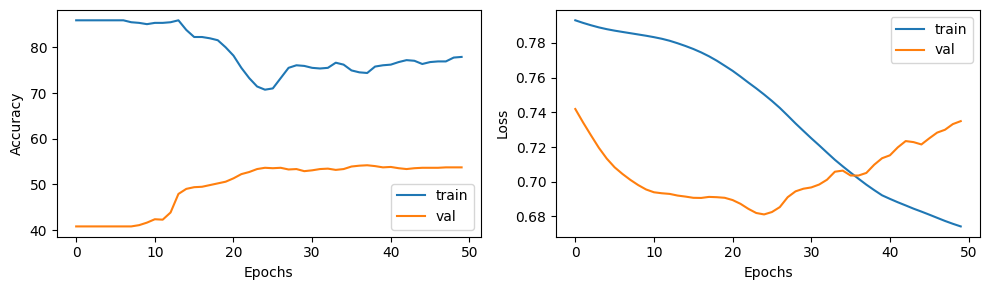

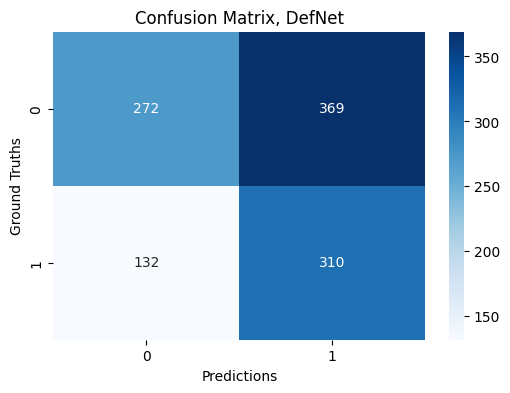

              precision    recall  f1-score   support

           0       0.67      0.42      0.52       641
           1       0.46      0.70      0.55       442

    accuracy                           0.54      1083
   macro avg       0.56      0.56      0.54      1083
weighted avg       0.58      0.54      0.53      1083



In [200]:
save_dir= fr'.\nets\compas\iter_{iter}\inacc_nt_models'
model_name= '16_8_inacc_nt'

training_history, validation_history = net_trainer(small_net, optimizer,
                                             criterion, device, inacc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)



Tau Threshold

In [201]:
model_path = fr'.\nets\compas\iter_{iter}\inacc_nt_models\16_8_inacc_nt_model_50.pt' 

small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.6
0.5601783060921248


##### Net 2: 32/16

tau 0.57

In [ ]:
# yet again, need to weigh class 0 to 5.0 + introduce label smoothing

# terrible results but possibly justified by the user
set_all_seeds(42)

large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.25)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(),
                       lr=0.001,
                       weight_decay= 1e-2

                    )

weights = torch.tensor([5.0, 1.0]).to(device) #1.1 troppo basso
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
scheduler = StepLR(optimizer, step_size=18, gamma=0.8) 

Training

Training Results - Epoch[1] Avg accuracy: 0.86 Avg loss: 0.76
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.74
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.86 Avg loss: 0.76
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.73
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.86 Avg loss: 0.76
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.86 Avg loss: 0.76
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.86 Avg loss: 0.76
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.86 Avg loss: 0.76
Validation Results - Epoch[6] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

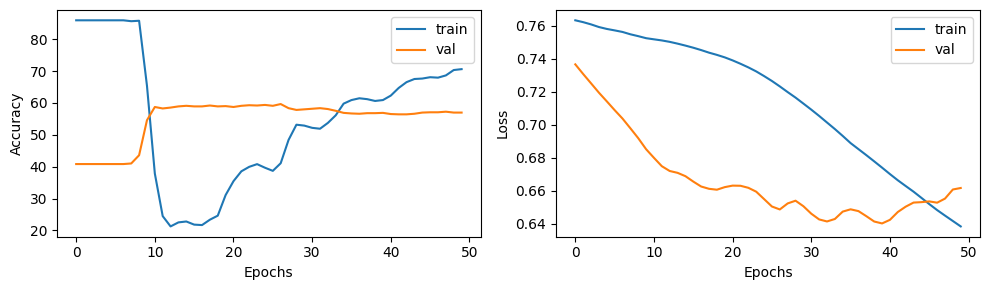

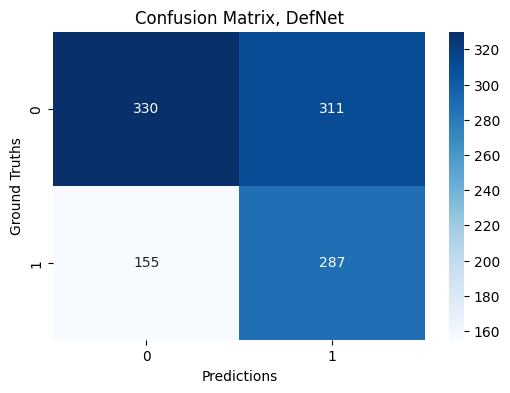

              precision    recall  f1-score   support

           0       0.68      0.51      0.59       641
           1       0.48      0.65      0.55       442

    accuracy                           0.57      1083
   macro avg       0.58      0.58      0.57      1083
weighted avg       0.60      0.57      0.57      1083



In [221]:
save_dir= fr'.\nets\compas\iter_{iter}\inacc_nt_models'
model_name= '32_16_inacc_nt'

training_history, validation_history = net_trainer(large_net, optimizer,
                                             criterion, device, inacc_nt_loader, val_loader,
                                             scheduler, iter, model_name, save_dir,
                                             log_interval=100, patience=25, max_epochs=50)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)


Tau Threshold

In [222]:
# dopo avere scelto la net migliore

model_path = fr'.\nets\compas\iter_3\inacc_nt_models\32_16_inacc_nt_model_50.pt'
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.5700000000000001
0.5897058823529412


#### Deferral Strat 2 

    tau             acc           def rate

24  0.272857       0.748242       0.234880

25  0.277143       0.729958       0.129395

26  0.281429       0.718706       0.068917

In [225]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_inacc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [226]:
# sulla base di x_def chiamo la rete 
# same configuration as iter 2
set_all_seeds(42)
r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff= 0.18)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [227]:
save_dir = fr'.\r_nets\compas\iter_{iter}'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(30):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/30 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_inacc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/30 - Loss: 0.5963
Epoch 2/30 - Loss: 0.5845
Epoch 3/30 - Loss: 0.5744
Epoch 4/30 - Loss: 0.5733
Epoch 5/30 - Loss: 0.5585
Epoch 6/30 - Loss: 0.5547
Epoch 7/30 - Loss: 0.5375
Epoch 8/30 - Loss: 0.5241
Epoch 9/30 - Loss: 0.5143
Epoch 10/30 - Loss: 0.5048
Epoch 11/30 - Loss: 0.4847
Epoch 12/30 - Loss: 0.4642
Epoch 13/30 - Loss: 0.4574
Epoch 14/30 - Loss: 0.4546
Epoch 15/30 - Loss: 0.4461
Epoch 16/30 - Loss: 0.4493
Epoch 17/30 - Loss: 0.4460
Epoch 18/30 - Loss: 0.4508
Epoch 19/30 - Loss: 0.4467
Epoch 20/30 - Loss: 0.4552
Epoch 21/30 - Loss: 0.4449
Epoch 22/30 - Loss: 0.4487
Epoch 23/30 - Loss: 0.4503
Epoch 24/30 - Loss: 0.4438
Epoch 25/30 - Loss: 0.4478
Epoch 26/30 - Loss: 0.4514
Epoch 27/30 - Loss: 0.4368
Epoch 28/30 - Loss: 0.4484
Epoch 29/30 - Loss: 0.4501
Epoch 30/30 - Loss: 0.4378
✅ r_net salvata correttamente in .\r_nets\compas\iter_3


In [230]:
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.3)

net_path= fr".\nets\compas\iter_{iter}\inacc_nt_models\32_16_inacc_nt_model_50.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)
large_net.eval()

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.17, 0.38, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.170000       1.000000       1.000000
1   0.174286       1.000000       1.000000
2   0.178571       1.000000       1.000000
3   0.182857       1.000000       1.000000
4   0.187143       1.000000       1.000000
5   0.191429       1.000000       1.000000
6   0.195714       1.000000       1.000000
7   0.200000       1.000000       1.000000
8   0.204286       1.000000       1.000000
9   0.208571       1.000000       1.000000
10  0.212857       1.000000       1.000000
11  0.217143       1.000000       0.998594
12  0.221429       1.000000       0.998594
13  0.225714       0.998594       0.995781
14  0.230000       0.998594       0.994374
15  0.234286       0.998594       0.992968
16  0.238571       0.991561       0.974684
17  0.242857       0.980309       0.949367
18  0.247143       0.964838       0.918425
19  0.251429       0.936709       0.863572
20  0.255714       0.907173       0.787623
21  0.260000       0.864979       0.641350
22  0.26428